In [1]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cf39e47273f6ba64ac0e916e1ba49ac8c2c10c1848654b7aae602eeb8be4aa04
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [2]:
# General Libraries
import re
import gc
import os
import cv2
import copy
import math
import shutil
from tqdm import tqdm
from time import time
import datetime as dtime
from pprint import pprint
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Get image path
base_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/"
''
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train["path"] = all_paths

display(train.head())

100%|██████████| 54706/54706 [00:05<00:00, 9359.77it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [4]:
def handle_directory(path, folder_name, erase=False):
    # Create the full path to the folder
    folder_path = os.path.join(path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        if erase:
            # If erase is True, delete the folder and its contents
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_name}' at '{path}' has been erased.")
        else:
            print(f"Folder '{folder_name}' already exists and erase is set to False. No action taken.")
    else:
        print(f"Folder '{folder_name}' does not exist. Creating it now.")
    
    # Create the folder (this will happen after deletion if erase was True)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_name}' has been created at '{path}'.")
    return folder_path

def extract_ids(path):
    # Split the path by slashes to extract parts
    parts = path.split('/')
    
    # The last two elements are id_patient and id_image
    id_patient = parts[-2]
    id_image = parts[-1].split('.')[0]  # Remove the file extension to get the id_image
    
    return id_patient, id_image

def fit_image(path_image, folder_path):
    # Reading the image using OpenCV
    X = cv2.imread(path_image)
    
    # Storing the original image for comparison
    original_image = X.copy()
    
    # Get the dimensions of the original image
    height_org, width_org, _ = original_image.shape

    # Cutting off the narrow exterior "frames"
    X = X[5:-5, 5:-5]

    # Creating a binary mask of non-empty pixels
    binary_mask = (X > 20).astype(np.uint8)[:, :, 0]

    # Finding connected components with statistics
    output = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

    # Extracting the statistics of the connected components
    stats = output[2]

    # Finding the largest area which is presumed to be the main data region
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h

    # Cropping the image to the main data region
    X_fit = X[y1: y2, x1: x2]

    # Get the dimensions of the cropped image
    height_crop, width_crop = X_fit.shape[:2]

    patient_id, image_id = extract_ids(path_image)

    # Creating directory for the patient if it doesn't exist
    output_dir = os.path.join(folder_path, patient_id)
    os.makedirs(output_dir, exist_ok=True)

    # Saving the processed image
    output_path = os.path.join(output_dir, f'{image_id}.png')
    cv2.imwrite(output_path, X_fit[:, :, 0])
    
    return output_path, patient_id, image_id, (width_org, height_org), (width_crop, height_crop)

def fit_all_images(all_images, folder_path):
    data = []
    # Process each image sequentially
    for fname in tqdm(all_images, total=len(all_images)):
        output_dir, patient_id, image_id, dimensions_org, dimensions_crop = fit_image(fname, folder_path)
        data.append({
            'patient_id': patient_id,
            'image_id': image_id,
            'dimensions_org': dimensions_org,  # Store original dimensions as a tuple
            'dimensions_crop': dimensions_crop,  # Store cropped dimensions as a tuple
            'path_image_processed': output_dir
        })
    df = pd.DataFrame(data)
    return df

def handle_directory(base_path, folder_name, erase=False):
    """
    Handle the creation of the directory where the processed images will be saved.
    
    Parameters:
    base_path (str): The base directory path.
    folder_name (str): The name of the folder to be created or used.
    erase (bool): Whether to erase the folder if it already exists.
    
    Returns:
    str: The path to the directory where images will be saved.
    """
    folder_path = os.path.join(base_path, folder_name)
    
    if erase and os.path.exists(folder_path):
        # If the folder exists and erase flag is True, remove the folder and its contents
        shutil.rmtree(folder_path)
    
    # Create the directory if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    return folder_path

def process_images(train, kaggle_path, folder_name='Processed Image', flag_processed_image=False,erase=False):
    """
    Process images and save the results in a CSV file.

    Parameters:
    train (pd.DataFrame): DataFrame containing the paths to the images.
    kaggle_path (str): Base path for saving the processed images and CSV.
    folder_name (str): Name of the folder to save processed images. Default is 'Processed Image'.
    flag_processed_image (bool): Flag to process images if True, else load from CSV. Default is True.

    Returns:
    pd.DataFrame: DataFrame containing processed image data.
    """
    # Handle the directory where processed images will be saved
    path_processed_image = handle_directory(kaggle_path, folder_name, erase=erase)
    
    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_image_processed.csv')
    
    if flag_processed_image:
        # Extract paths of images to process
        path_images = train['path'].values.tolist() #[:10]
        # Process all images
        data_image = fit_all_images(path_images, path_processed_image)
        # Save the processed image data to CSV
        data_image.to_csv(path_saved, index=False)
        print(f"Dataframe saved to: {path_saved}")
    else:
        # Load processed image data from CSV
        data_image = pd.read_csv(path_saved)
    
    # Display the first few rows of the DataFrame
    display(data_image.head())
    
    return data_image

def merge_data(train, train_processed):
    print("Displaying the first few rows of the train dataset:")
    display(train.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train dataset:")
    print(train[['patient_id', 'image_id']].dtypes)
    
    print("Displaying the first few rows of the train_processed dataset:")
    display(train_processed.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...")
    train_processed['patient_id'] = train_processed['patient_id'].astype('int64')
    train_processed['image_id'] = train_processed['image_id'].astype('int64')

    print("Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...")
    merged_df = pd.merge(train, train_processed, on=['patient_id', 'image_id'])
    
    print("Displaying the first few rows of the merged dataset:")
    display(merged_df.head())
    
    return merged_df


In [5]:
kaggle_path = '/kaggle/working/'
data_image = process_images(train, kaggle_path,flag_processed_image=True,erase=True)

100%|██████████| 54706/54706 [15:12<00:00, 59.95it/s]


Dataframe saved to: /kaggle/working/train_image_processed.csv


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [7]:
data = merge_data(train, data_image)

Displaying the first few rows of the train dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


Displaying the data types of 'patient_id' and 'image_id' in the train dataset:
patient_id    int64
image_id      int64
dtype: object
Displaying the first few rows of the train_processed dataset:


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    int64
image_id      int64
dtype: object
Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...
Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    int64
image_id      int64
dtype: object
Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...
Displaying the first few rows of the merged dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,dimensions_org,dimensions_crop,path_image_processed
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [8]:
def prepare_data(data, kaggle_path):
    # Map the 'cancer' column to a new 'labels' column
    data['labels'] = data['cancer'].map({0: 'No Cancer', 1: 'Cancer'})
    print("Mapped 'cancer' column to 'labels' column.")

    # Check the number of missing values in the 'age' column before filling
    missing_before = data['age'].isnull().sum()
    print("Number of missing values in 'age' before filling:", missing_before)

    # Fill missing values in the 'age' column with 58
    data['age'] = data['age'].fillna(58)
    print("Filled missing values in 'age' column with 58.")

    # Check the number of missing values in the 'age' column after filling
    missing_after = data['age'].isnull().sum()
    print("Number of missing values in 'age' after filling:", missing_after)

    # Select specified columns
    features = ["patient_id", "image_id", "laterality", "view", "age", "implant", "cancer", "labels", "path_image_processed"]
    data = data[features]
    print("Selected specified columns.")
    
    data = tranform_categorical(data.copy())

    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_clean.csv')
    print(f"Path to save the CSV file: {path_saved}")

    # Save the cleaned data to CSV
    data.to_csv(path_saved, index=False)
    print("Saved the cleaned data to CSV.")

    return data

def tranform_categorical(data):
    """
    Encode categorical variables in the dataset.
    
    Parameters:
    - data: A pandas DataFrame containing the data with categorical variables 'laterality' and 'view'.
    
    Returns:
    - data: A pandas DataFrame with the categorical variables encoded as integers.
    """
    # Initialize LabelEncoders for categorical variables
    le_laterality = LabelEncoder()
    le_view = LabelEncoder()

    # Encode 'laterality' and 'view' columns
    data['laterality'] = le_laterality.fit_transform(data['laterality'])
    data['view'] = le_view.fit_transform(data['view'])

    return data

In [9]:
kaggle_path = '/kaggle/working/'
cleaned_data = prepare_data(data.copy(), kaggle_path)
display(cleaned_data)

Mapped 'cancer' column to 'labels' column.
Number of missing values in 'age' before filling: 37
Filled missing values in 'age' column with 58.
Number of missing values in 'age' after filling: 0
Selected specified columns.
Path to save the CSV file: /kaggle/working/train_clean.csv
Saved the cleaned data to CSV.


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,10006,462822612,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,0,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,1,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,0,1,55.0,0,0,No Cancer,/kaggle/working/Processed Image/10011/22037523...
...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,No Cancer,/kaggle/working/Processed Image/9973/172952472...
54702,9989,63473691,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/63473691.png
54703,9989,1078943060,0,1,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/107894306...
54704,9989,398038886,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/398038886...


In [10]:
def plot_label_distribution(train,dataset_type='Train'):
    """
    Plot the distribution of labels in the DataFrame `train`.

    Parameters:
    train (pd.DataFrame): DataFrame containing the label data.

    The DataFrame must have a column named 'labels'.
    """
    counts = train['labels'].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot: bar chart
    bars = ax1.bar(counts.index, counts.values, color=sns.color_palette("pastel"))

    # Format the number with commas and display it above the bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / len(train)) * 100  # Calculate the percentage
        ax1.text(bar.get_x() + bar.get_width() / 2, height + (max(counts.values) * 0.02), 
                 f"{height:,.0f}\n({percentage:.1f}%)", ha='center', va='bottom', color='black', fontsize=10)

    #ax1.set_xlabel('Different types of labels in the Cancer column',loc='center')
    ax1.set_ylabel('Frequency')
    #ax1.set_title('Analysis of the target column Cancer', color='red')
    ax1.set_title(f'{dataset_type.capitalize()} Dataset: Analysis of the target column Cancer', color='red')

    # Show both horizontal and vertical grid lines
    ax1.grid(axis='both', linestyle='-', alpha=0.5)

    # Adjust y-limit to ensure text fits within the figure
    ax1.set_ylim(0, max(counts.values) * 1.2)

    # Second subplot: pie chart
    wedges, texts, autotexts = ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, 
                                       colors=sns.color_palette("pastel"), textprops=dict(color="w"))

    for text in texts:
        text.set_color('black')
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
    
    #ax2.set_title('Distribution of labels', color='blue')
    ax2.set_title(f'{dataset_type.capitalize()} Dataset: Distribution of labels', color='red')

    # Adjust spacing between the two subplots
    plt.subplots_adjust(wspace=0.1)

    # Add a text box with the message
    message = f'The {dataset_type} dataset has {len(train)} samples with the following label distribution.'
    plt.figtext(0.5, 0.01, message, wrap=True, horizontalalignment='center', fontsize=11, color='black')

    plt.show()
    
def create_train_test_subsets(df, target_column, num_class_0_test, num_class_1_test):
    """
    This function takes a dataset and the name of a target column, selects a specific number of elements for each class (0 and 1)
    from the dataset for the test set. The function then determines how many samples should be in the training set
    to ensure there is no overlap and that all data is used.

    Args:
    - df (pd.DataFrame): The dataset to process.
    - target_column (str): The name of the target column.
    - num_class_0_test (int): The number of elements to select for class 0 in the test set.
    - num_class_1_test (int): The number of elements to select for class 1 in the test set.

    Returns:
    - pd.DataFrame: The training dataset.
    - pd.DataFrame: The test dataset.
    """
    
    # Separate the dataset into two subsets based on the target column value
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Check if the requested number of test samples is available
    if num_class_0_test > len(df_class_0) or num_class_1_test > len(df_class_1):
        raise ValueError("Not enough samples available for the specified test set sizes.")
    
    # Select the samples for the test set
    df_class_0_test = df_class_0.sample(n=num_class_0_test, random_state=42).drop_duplicates()
    df_class_1_test = df_class_1.sample(n=num_class_1_test, random_state=42).drop_duplicates()
    
    # Determine the number of samples for the training set
    df_class_0_train = df_class_0.drop(df_class_0_test.index)
    df_class_1_train = df_class_1.drop(df_class_1_test.index)
    
    # Combine the training samples for both classes
    df_train = pd.concat([df_class_0_train, df_class_1_train]).reset_index(drop=True)
    
    # Combine the test samples for both classes
    df_test = pd.concat([df_class_0_test, df_class_1_test]).reset_index(drop=True)
    
    # Shuffle the rows of the training and test datasets
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_train, df_test

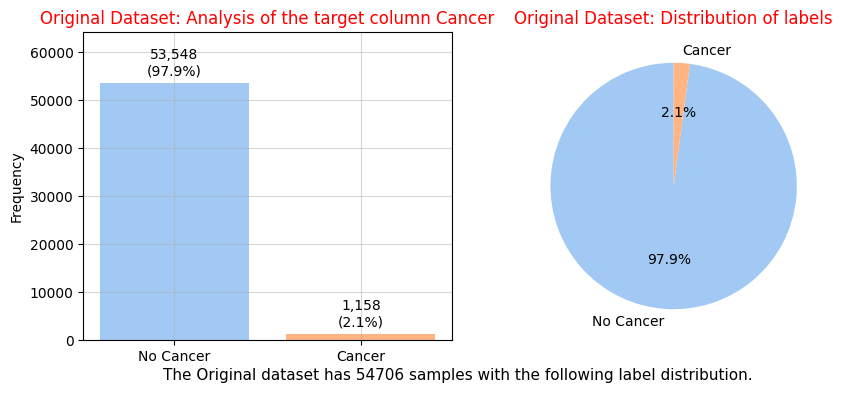

In [11]:
plot_label_distribution(cleaned_data,'Original')

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataset_model_1(df):
    """
    Divise un dataset en ensembles d'entraînement et de test pour le Modèle 1, selon les classes spécifiées.

    Pour le Modèle 1, les ensembles sont divisés comme suit :
    - Classe "No Cancer": 42838 images pour l'entraînement, 10710 images pour le test
    - Classe "Cancer": 926 images pour l'entraînement, 232 images pour le test

    Paramètres:
    df (DataFrame): Le dataset contenant les images et leurs étiquettes.

    Retourne:
    Tuple[DataFrame, DataFrame]: Deux DataFrames contenant les ensembles d'entraînement et de test respectivement.
    """
    # Filtrer les données pour la classe "Cancer" et "No Cancer"
    cancer_data = df[df['labels'] == 'Cancer']
    no_cancer_data = df[df['labels'] == 'No Cancer']

    # Vérification des tailles des datasets
    print(f"Total Cancer images: {len(cancer_data)}")
    print(f"Total No Cancer images: {len(no_cancer_data)}")

    # Diviser les données "Cancer" en ensembles d'entraînement et de test
    cancer_train, cancer_test = train_test_split(cancer_data, train_size=926, test_size=232, random_state=42, shuffle=True)

    # Diviser les données "No Cancer" en ensembles d'entraînement et de test
    no_cancer_train, no_cancer_test = train_test_split(no_cancer_data, train_size=42838, test_size=10710, random_state=42, shuffle=True)

    # Combiner les ensembles d'entraînement et de test
    train_data = pd.concat([cancer_train, no_cancer_train])
    test_data = pd.concat([cancer_test, no_cancer_test])

    # Réinitialiser les index et mélanger les données
    train_data = train_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)
    test_data = test_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)

    # Retourner les datasets divisés
    return train_data, test_data

def split_dataset_model_2(df):
    """
    Divise un dataset en ensembles d'entraînement et de test pour le Modèle 2, en traitant le déséquilibre des classes.

    Pour le Modèle 2, les ensembles sont divisés comme suit :
    - Classe "No Cancer": 4000 images pour l'entraînement, 1000 images pour le test (sélection sur un sous-ensemble de 5000 images)
    - Classe "Cancer": 926 images pour l'entraînement, 232 images pour le test (sélection sur l'ensemble complet de 1158 images)

    Paramètres:
    df (DataFrame): Le dataset contenant les images et leurs étiquettes.

    Retourne:
    Tuple[DataFrame, DataFrame]: Deux DataFrames contenant les ensembles d'entraînement et de test respectivement.
    """
    # Filtrer les données pour la classe "Cancer" et "No Cancer"
    cancer_data = df[df['labels'] == 'Cancer']
    no_cancer_data = df[df['labels'] == 'No Cancer']

    # Vérification des tailles des datasets
    print(f"Total Cancer images: {len(cancer_data)}")
    print(f"Total No Cancer images: {len(no_cancer_data)}")

    # Sélectionner un sous-ensemble de 5000 images pour la classe "No Cancer"
    no_cancer_data_sample = no_cancer_data.sample(n=5000, random_state=42)

    # Diviser les données "Cancer" en ensembles d'entraînement et de test
    cancer_train, cancer_test = train_test_split(cancer_data, train_size=926, test_size=232, random_state=42, shuffle=True)

    # Diviser les données "No Cancer" en ensembles d'entraînement et de test
    no_cancer_train, no_cancer_test = train_test_split(no_cancer_data_sample, train_size=4000, test_size=1000, random_state=42, shuffle=True)

    # Combiner les ensembles d'entraînement et de test
    train_data = pd.concat([cancer_train, no_cancer_train])
    test_data = pd.concat([cancer_test, no_cancer_test])

    # Réinitialiser les index et mélanger les données
    train_data = train_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)
    test_data = test_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)

    # Retourner les datasets divisés
    return train_data, test_data

In [13]:
# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
def plot_cases_count(df, title, ax):
    # Count the number of occurrences for each label and sort by index
    cases_count = df['labels'].value_counts().sort_index()

    # Create a bar plot with a custom color palette
    palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Custom colors: blue and orange
    sns.barplot(x=cases_count.index, y=cases_count.values, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case Type', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(cases_count.index, fontsize=12)
    
    # Add annotations for each bar
    for i, count in enumerate(cases_count.values):
        ax.text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 43764
Test data size: 10942


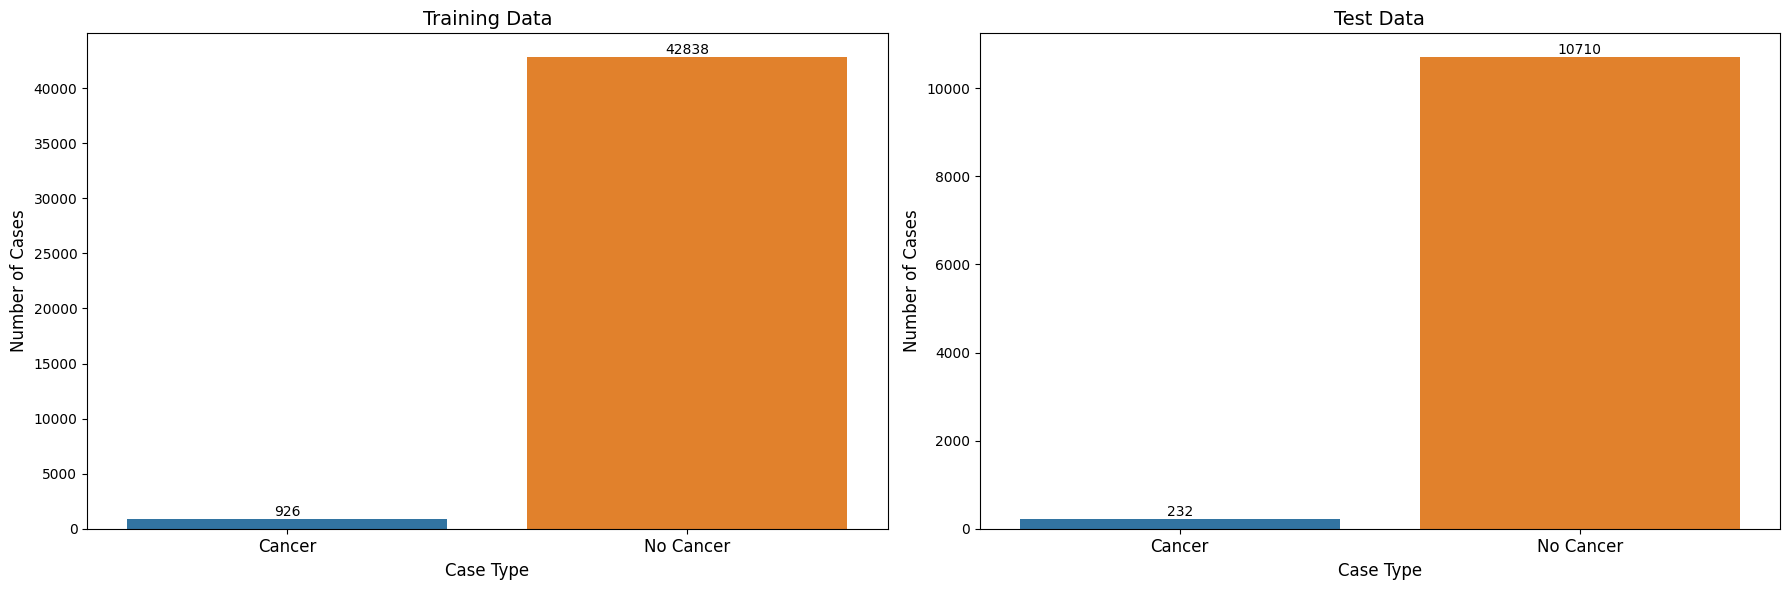

---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


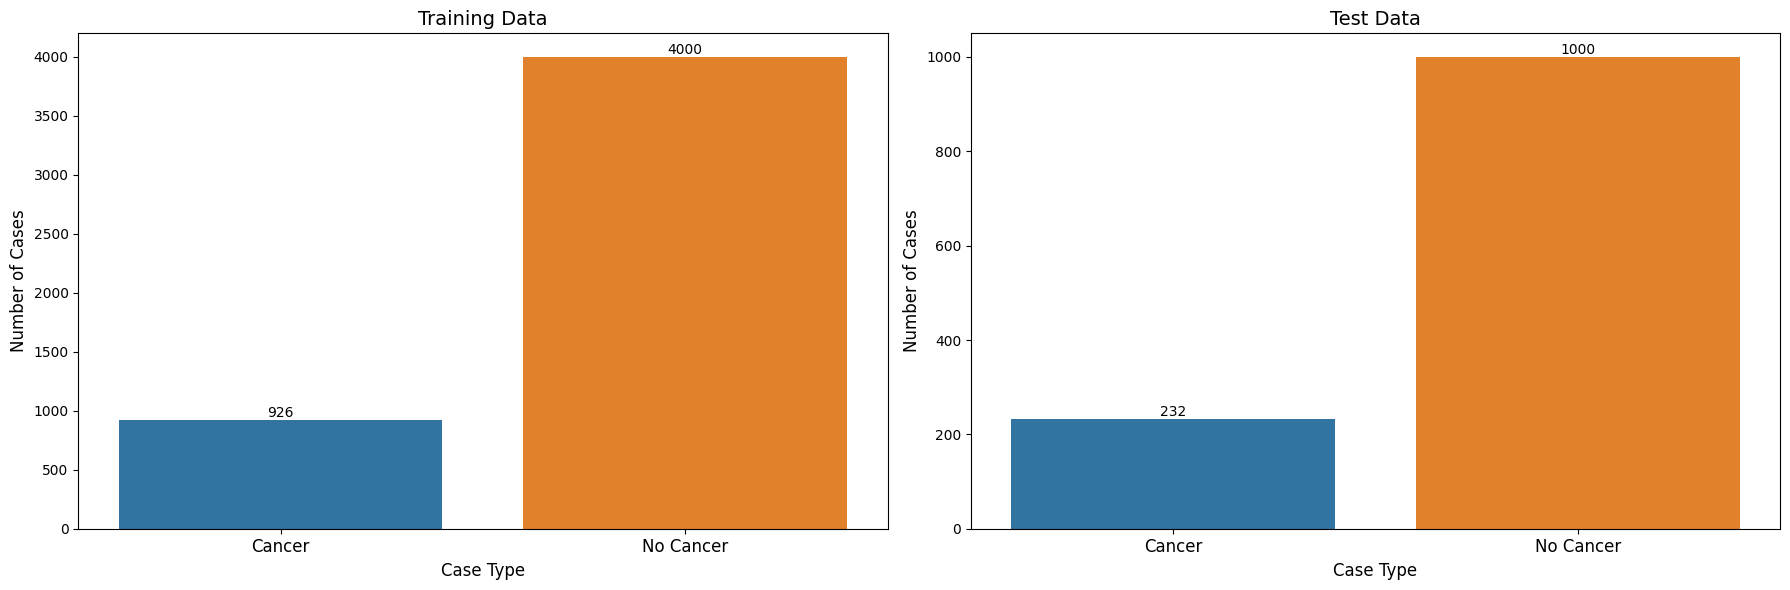

In [15]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 1
train_data, test_data = split_dataset_model_1(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [16]:
def create_subset_train(df, target_column, num_class_0, num_class_1):
    """
    Cette fonction prend un ensemble de données et le nom d'une colonne cible, sélectionne un nombre spécifique
    d'éléments pour chaque valeur de la colonne cible (0 et 1), puis fusionne ces sous-ensembles en un seul
    ensemble de données.

    Args:
    - df (pd.DataFrame): L'ensemble de données à traiter.
    - target_column (str): Le nom de la colonne cible.
    - num_class_0 (int): Le nombre d'éléments à sélectionner pour la classe 0.
    - num_class_1 (int): Le nombre d'éléments à sélectionner pour la classe 1.

    Returns:
    - pd.DataFrame: L'ensemble de données fusionné contenant des sous-ensembles équilibrés.
    """
    
    # Séparer l'ensemble de données en deux sous-ensembles en fonction de la valeur de la colonne cible
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Sélectionner un échantillon de taille num_class_0 à partir du sous-ensemble de la classe 0 sans répétition
    df_class_0_sample = df_class_0.sample(n=num_class_0, random_state=42).drop_duplicates()
    
    # Sélectionner un échantillon de taille num_class_1 à partir du sous-ensemble de la classe 1 sans répétition
    df_class_1_sample = df_class_1.sample(n=num_class_1, random_state=42).drop_duplicates()
    
    # Fusionner les deux échantillons en un seul ensemble de données
    df_sample = pd.concat([df_class_0_sample, df_class_1_sample]).reset_index(drop=True)
    
    # Mélanger les lignes de l'ensemble de données résultant
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_sample

---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 43764
Test data size: 10942


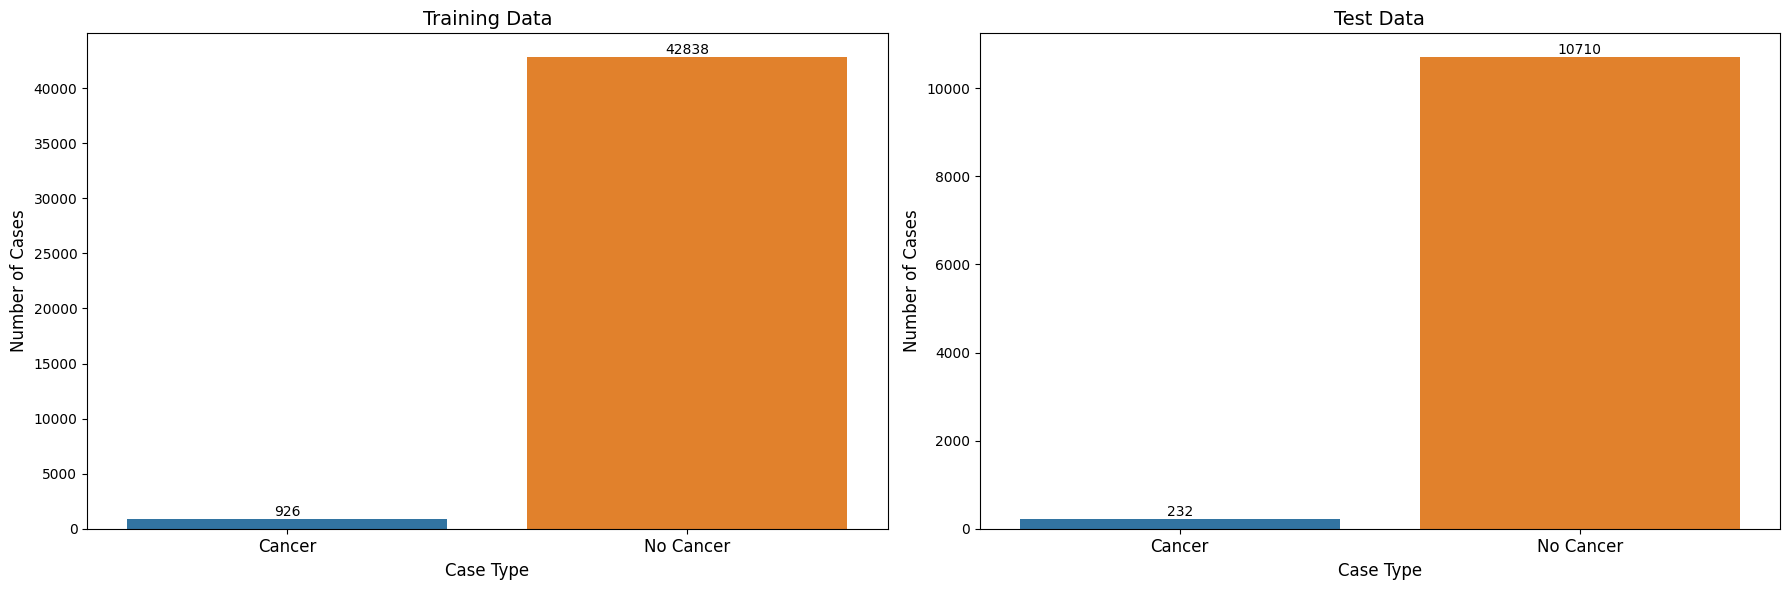

In [17]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 1
train_data, test_data = split_dataset_model_1(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [18]:
# PyTorch
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize, RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise, Rotate, RandomResizedCrop, ShiftScaleRotate, ToGray)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='albumentations')

import logging
logging.getLogger('albumentations').setLevel(logging.ERROR)

# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'


class My_Custom_RSNA_Dataset(Dataset): 
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}


In [19]:
def set_seed(seed=42):
    """
    Set the seed for generating random numbers.
    
    Args:
        seed (int): The seed to use for the random number generators.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def data_to_device(data):
    """
    Transfer data to the specified device (e.g., CPU or GPU).

    Args:
    data (tuple): A tuple containing the data components to be transferred to the device.
                  Typically, it consists of image, metadata, and targets.

    Returns:
    tuple: A tuple containing the transferred data components, now residing on the specified device.
    """
    # Extract components from the input tuple
    image, metadata, targets = data.values()
    
    # Transfer each component to the specified device
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [20]:
# ----- GLOBAL PARAMS ------
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# --------------------------
# Use the set_seed function to initialize the seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cuda


In [21]:
# Sample data
sample = train_data.head(10) #train_data, test_data

# Instantiate Dataset object
dataset = My_Custom_RSNA_Dataset(sample,csv_columns) #CustomRSNADataset(sample,csv_columns,is_train=True)

# The Dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=False,num_workers=4)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(Color.S + f"Batch: {k}" + Color.E, "\n" + Color.S + "Image:" + Color.E, image.shape, "\n" + Color.S + "Meta:" + Color.E, meta, "\n" + Color.S + "Targets:" + Color.E, targets, "\n" + "="*50)

Batch: 0 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 50.,  0.],
        [ 0.,  5., 66.,  0.],
        [ 1.,  1., 51.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 1.,  1., 48.,  0.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 
Batch: 1 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 65.,  0.],
        [ 1.,  5., 40.,  0.],
        [ 0.,  5., 53.,  0.],
        [ 0.,  5., 56.,  0.],
        [ 0.,  1., 65.,  0.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 


In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(1,1), gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, preds, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.flatten(preds), torch.flatten(targets).float())
        logits=nn.Sigmoid()(preds)
        F_loss = (self.alpha[0]*(targets)*((1-logits)**self.gamma)+ self.alpha[1]*(1-targets)*((logits)**self.gamma)) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [23]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [24]:
# Load Model
EffNetNet_model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = EffNetNet_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example =FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 40.9MB/s]


Loaded pretrained weights for efficientnet-b2
Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1408])
Meta Data: torch.Size([5, 250])
Concatenated Data: torch.Size([5, 1658])
Out shape: torch.Size([5, 1])
Loss: 0.10861670970916748


In [25]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [26]:
# Load Model
ResNet50_model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = ResNet50_model(image, meta, prints=True)

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example = FocalLoss(alpha=(50,1))

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s] 


Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1000])
Meta Data: torch.Size([5, 500])
Concatenated Data: torch.Size([5, 1500])
Out shape: torch.Size([5, 1])
Loss: 0.10904983431100845


In [27]:
def create_or_recreate_folder(base_path, folder_name):
    folder_path = os.path.join(base_path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Remove the folder if it exists
        shutil.rmtree(folder_path)
    
    # Create the folder
    os.makedirs(folder_path)
    
    return folder_path

def create_directory(base_path, folder_name, is_true=False):
    """
    Create a directory if it doesn't exist. Optionally, delete existing directory and recreate it.

    Args:
    - base_path (str): The base path where the directory should be created.
    - folder_name (str): The name of the directory to be created.
    - is_true (bool, optional): If True, delete existing directory and recreate it. Default is False.

    Returns:
    - new_dir_path (str or None): The full path of the created directory, or None if creation failed.
    """
    # Full path of the new directory
    new_dir_path = os.path.join(base_path, folder_name)
    
    # Check if the base path exists
    if os.path.exists(base_path):
        # If the directory doesn't exist, create it
        if not os.path.exists(new_dir_path):
            os.makedirs(new_dir_path)
            print(f"Directory '{folder_name}' created successfully at: {new_dir_path}")
        else:
            # If the directory already exists
            print(f"Directory '{folder_name}' already exists at: {new_dir_path}")
            if is_true:
                # Delete the existing directory and recreate it
                shutil.rmtree(new_dir_path)
                os.makedirs(new_dir_path)
                print(f"Directory '{folder_name}' recreated successfully at: {new_dir_path}")
    else:
        # If the base path doesn't exist
        print(f"The path '{base_path}' specified does not exist.")
        new_dir_path = None
    
    return new_dir_path

def create_logs_file(logs_directory, version):
    """
    Creates a logs file inside the specified directory.

    Args:
        logs_directory (str): The directory where the logs file will be created.
        version (str): The version identifier to be included in the logs file name.

    Returns:
        tuple: A tuple containing the file object of the created logs file and the logs directory path.
    """
    # Check if the directory exists, create it if not
    if not os.path.exists(logs_directory):
        os.makedirs(logs_directory)

    # Full path of the logs file
    log_file_path = os.path.join(logs_directory, f"logs_{version}.txt")

    # Create a .txt file for logs
    f = open(log_file_path, "w+")

    return log_file_path


def add_in_file(text, file_path):
    """
    Add text to the end of a file.

    Args:
    text (str): The text to be added to the file.
    file_path (str): The path of the file where the text will be added.

    Returns:
    None
    """
    # Open the file in 'append' mode to add text at the end
    with open(file_path, 'a+') as file:
        # Write the text to the file
        print(text, file=file)

def read_logs_file(log_file_path):
    """
    Read the content of a logs file and print it.

    Args:
    log_file_path (str): The full path of the logs file to be read.

    Returns:
    None
    """
    # Check if the file exists
    if os.path.exists(log_file_path):
        # Open the file and read its content
        with open(log_file_path, "r") as f:
            logs_content = f.read()
        # Print the content
        print(logs_content)
    else:
        print("Logs file not found.")
        
def drop_files_in_directory(directory):
    """
    Drops all files inside the specified directory.

    Args:
    directory (str): The directory path where files will be dropped.

    Returns:
    None
    """
    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            # Check if the path is a file
            if os.path.isfile(file_path):
                # Remove the file
                os.remove(file_path)
    else:
        print("Directory does not exist.")

def close_file(log_file_path):
    """
    Close the log file safely.
    
    Parameters:
    log_file_path (str): The path to the log file.
    """
    try:
        with open(log_file_path, 'a') as file:
            file.write("\n--- Log File Closed ---\n")
        print(f"Log file at {log_file_path} has been closed.")
    except Exception as e:
        print(f"Error occurred while closing the log file: {e}")


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    print('Finished Training')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [28]:
def display_dataset_statistics(train_data, valid_data):
    """
    Displays the statistics of the training and validation datasets.

    Args:
        train_data (pd.DataFrame): The training dataset containing features and labels.
        valid_data (pd.DataFrame): The validation dataset containing features and labels.
    """
    # Print the dimensions of train_data and valid_data
    #print("")
    print(f"Dimensions of train_data: {train_data.shape}")
    print(f"Dimensions of valid_data: {valid_data.shape}")
    #print("")

    y_train, y_valid = train_data['labels'], valid_data['labels']
    # Print the number of unique classes in y_train and y_valid
    num_classes_train = len(np.unique(y_train))
    num_classes_valid = len(np.unique(y_valid))
    #print(f"Number of unique classes in y_train: {num_classes_train}")
    #print(f"Number of unique classes in y_valid: {num_classes_valid}")
    #print("")
    
    # Print the number of instances per class in y_train and y_valid
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train.values == class_label)
        instances_valid = np.sum(y_valid.values == class_label)
        print(f"Class {class_label}: Training instances - {instances_train}, Validation instances - {instances_valid}")
        
def display_confusion_matrix(valid_targets, valid_preds_rounded):
    """
    Displays the confusion matrix and classification report for a given set of true labels and predicted labels.

    Args:
        valid_targets (array-like): True labels of the validation set.
        valid_preds_rounded (array-like): Predicted labels of the validation set.
    """
    # Replace 0 with "No Cancer" and 1 with "Cancer" in the predicted and true labels
    y_pred = np.where(np.array(valid_preds_rounded) == 0, "No Cancer", "Cancer")   #valid_predictions)
    y_true = np.where(np.array(valid_targets) == 0, "No Cancer", "Cancer")

    # Classification report
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=["No Cancer", "Cancer"])
    categories = ["No Cancer", "Cancer"]
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


In [29]:
def train_model_cross_validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            scheduler.step(val_loss)

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }


        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

In [40]:
def Train_Model_Applying_k_Fold_Cross_Validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = My_Custom_RSNA_Dataset(train_data, csv_columns) #CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = My_Custom_RSNA_Dataset(valid_data, csv_columns) #CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []
        
        # Initialisation du modèle
        # model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié


        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            # scheduler.step(val_loss)
            scheduler.step(val_f1) 

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }

        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

In [31]:
base_path = "/kaggle/working/"

# Nom du dossier à créer
folder_folder = "Best Model"
    
save_best_model_dir = create_directory(base_path,folder_folder,is_true=True)
print("Chemin du dossier créé :", save_best_model_dir)

logs_folder = "Logs"

logs_dir = create_directory(base_path,logs_folder, is_true=False)
print("Chemin du dossier créé :", logs_dir)

Directory 'Best Model' already exists at: /kaggle/working/Best Model
Directory 'Best Model' recreated successfully at: /kaggle/working/Best Model
Chemin du dossier créé : /kaggle/working/Best Model
Directory 'Logs' already exists at: /kaggle/working/Logs
Chemin du dossier créé : /kaggle/working/Logs


Shape Of Train Sample: (350, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,42760,42371207,1,5,67.0,0,0,No Cancer,/kaggle/working/Processed Image/42760/42371207...
1,19750,684882869,1,1,73.0,0,1,Cancer,/kaggle/working/Processed Image/19750/68488286...
2,23386,671342702,1,5,59.0,0,1,Cancer,/kaggle/working/Processed Image/23386/67134270...
3,6659,734832218,1,5,56.0,0,1,Cancer,/kaggle/working/Processed Image/6659/734832218...
4,17904,1747099388,0,1,50.0,0,0,No Cancer,/kaggle/working/Processed Image/17904/17470993...


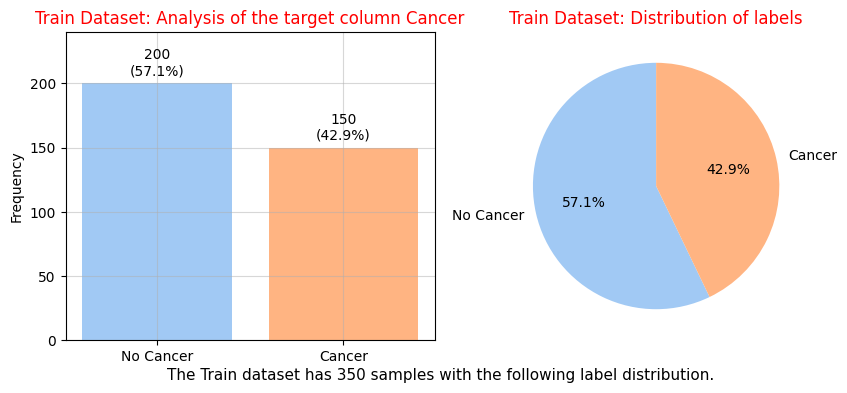

In [82]:
# Sample down for dev
num_class_0,num_class_1 = 200,150 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(train_data, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)
plot_label_distribution(train_data,'Train')

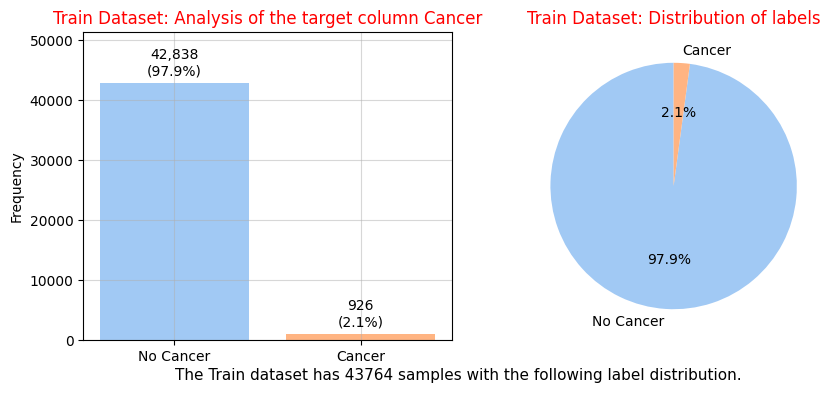

In [32]:
plot_label_distribution(train_data,'Train')

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 618, Validation instances - 308
Class No Cancer: Training instances - 28558, Validation instances - 14280
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.8, loss=0.00109]


Training metrics for Epoch 1:
Accuracy: 0.9775843158760625
ROC: 0.5009528102803787
Precision: 0.05
Recall: 0.003236245954692557
F1 score: 0.006079027355623101
Train loss: 0.0011
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:29<00:00,  4.91batch/s, accuracy=97.9, loss=0.000991]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Validation metrics for Epoch 1:
Accuracy: 0.9788867562380038
ROC: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.49      0.50      0.49     14588
weighted avg       0.96      0.98      0.97     14588



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


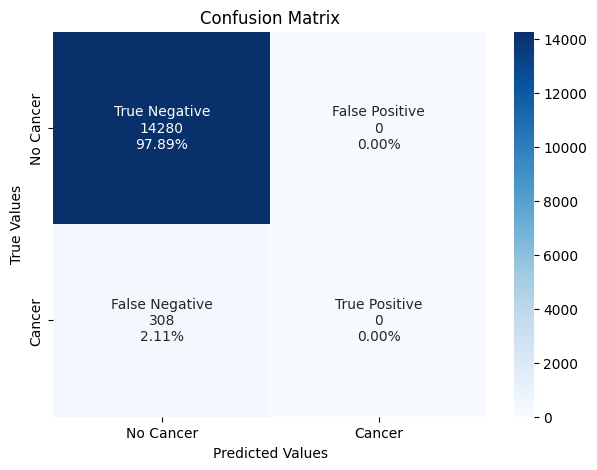

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000974]


Training metrics for Epoch 2:
Accuracy: 0.9787839319989032
ROC: 0.4999824917711324
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Train loss: 0.0010
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:29<00:00,  4.99batch/s, accuracy=97.9, loss=0.000974]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Validation metrics for Epoch 2:
Accuracy: 0.9788867562380038
ROC: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.49      0.50      0.49     14588
weighted avg       0.96      0.98      0.97     14588



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


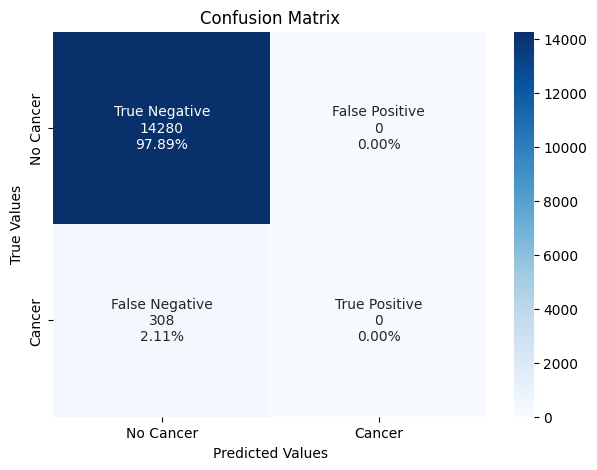

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000927]


Training metrics for Epoch 3:
Accuracy: 0.9788182067452701
ROC: 0.5071239793382502
Precision: 0.5
Recall: 0.014563106796116505
F1 score: 0.02830188679245283
Train loss: 0.0009
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:29<00:00,  4.95batch/s, accuracy=95.5, loss=0.00161]


Validation metrics for Epoch 3:
Accuracy: 0.9546887853029887
ROC: 0.5559396485867074
Precision: 0.0979498861047836
Recall: 0.1396103896103896
F1 score: 0.11512717536813923
Validation Loss: 0.0016
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.10      0.14      0.12       308
   No Cancer       0.98      0.97      0.98     14280

    accuracy                           0.95     14588
   macro avg       0.54      0.56      0.55     14588
weighted avg       0.96      0.95      0.96     14588



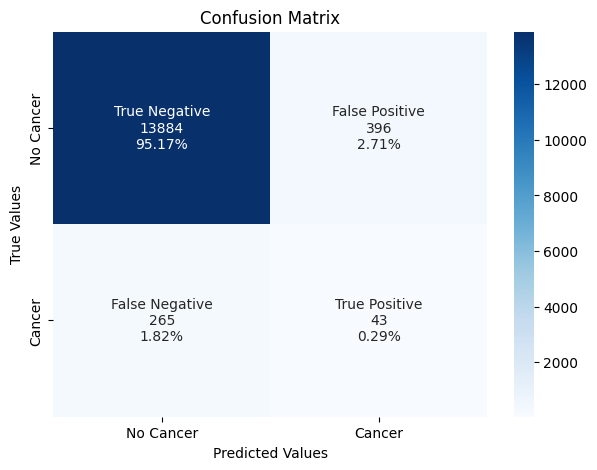

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000894]


Training metrics for Epoch 4:
Accuracy: 0.9791952289553058
ROC: 0.5199814220126825
Precision: 0.6410256410256411
Recall: 0.040453074433656956
F1 score: 0.076103500761035
Train loss: 0.0009
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:29<00:00,  4.98batch/s, accuracy=97.9, loss=0.001]   


Validation metrics for Epoch 4:
Accuracy: 0.9788182067452701
ROC: 0.5063184364654952
Precision: 0.4444444444444444
Recall: 0.012987012987012988
F1 score: 0.02523659305993691
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.44      0.01      0.03       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.71      0.51      0.51     14588
weighted avg       0.97      0.98      0.97     14588



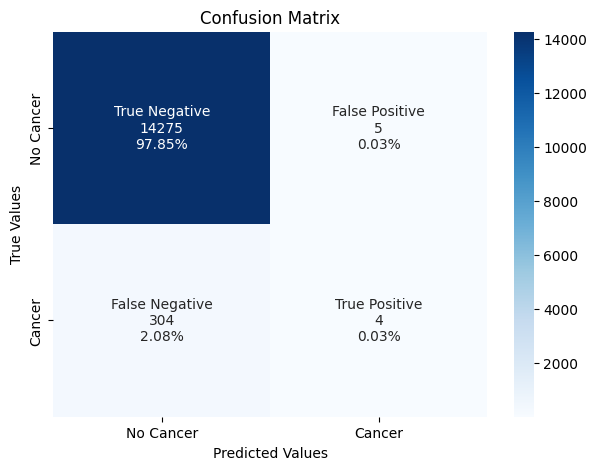

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98, loss=0.000783]  


Training metrics for Epoch 5:
Accuracy: 0.980223471346312
ROC: 0.5648336514278215
Precision: 0.6694214876033058
Recall: 0.13106796116504854
F1 score: 0.2192151556156969
Train loss: 0.0008
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:29<00:00,  4.96batch/s, accuracy=97.8, loss=0.00104]


Validation metrics for Epoch 5:
Accuracy: 0.9779270633397313
ROC: 0.5106283422459893
Precision: 0.25
Recall: 0.022727272727272728
F1 score: 0.04166666666666667
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.25      0.02      0.04       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.61      0.51      0.52     14588
weighted avg       0.96      0.98      0.97     14588



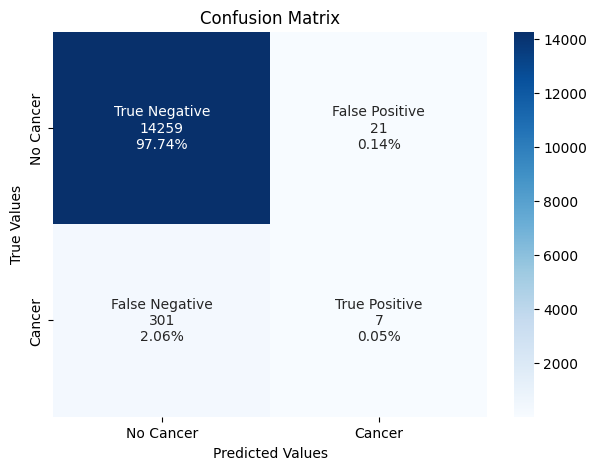

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Finished Training


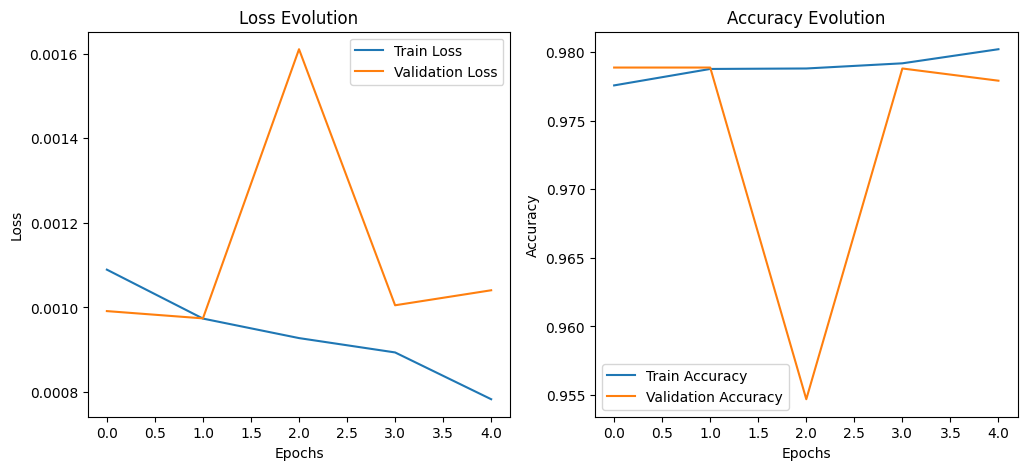

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.9779 Precision: 0.2500 Recall: 0.0227 F1: 0.1151 ROC: 0.5106
---------- Fold: 2 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 28559, Validation instances - 14279
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.2, loss=0.000777]


Training metrics for Epoch 1:
Accuracy: 0.9815259117082533
ROC: 0.5877878960005625
Precision: 0.7785714285714286
Recall: 0.1766612641815235
F1 score: 0.28797886393659183
Train loss: 0.0008
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:29<00:00,  4.93batch/s, accuracy=98.6, loss=0.000504]


Validation metrics for Epoch 1:
Accuracy: 0.986358650945983
ROC: 0.681159740547313
Precision: 0.9824561403508771
Recall: 0.36245954692556637
F1 score: 0.5295508274231678
Validation Loss: 0.0005
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.36      0.53       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.98      0.68      0.76     14588
weighted avg       0.99      0.99      0.98     14588



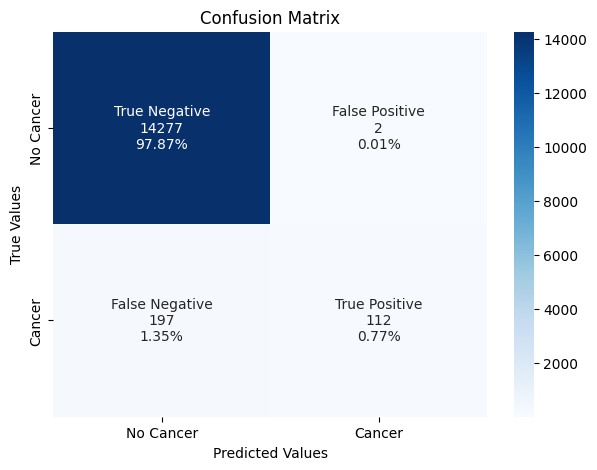

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.3, loss=0.000696]


Training metrics for Epoch 2:
Accuracy: 0.9831368247874965
ROC: 0.6227039556372337
Precision: 0.8491620111731844
Recall: 0.24635332252836303
F1 score: 0.3819095477386935
Train loss: 0.0007
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:28<00:00,  5.08batch/s, accuracy=98.8, loss=0.000452]


Validation metrics for Epoch 2:
Accuracy: 0.9880723882643269
ROC: 0.7200297084613587
Precision: 0.9927007299270073
Recall: 0.4401294498381877
F1 score: 0.6098654708520179
Validation Loss: 0.0005
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.44      0.61       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.99      0.72      0.80     14588
weighted avg       0.99      0.99      0.99     14588



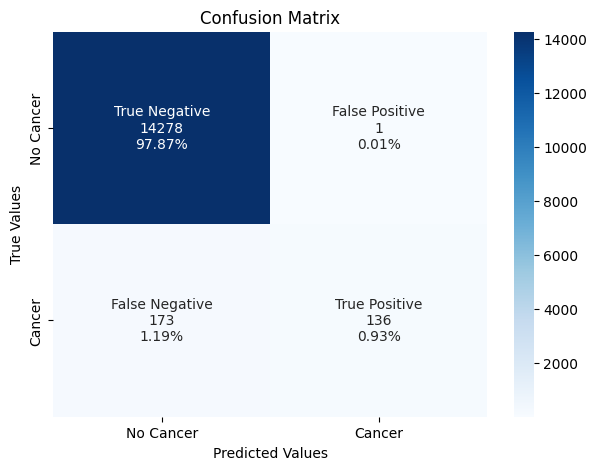

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.6, loss=0.000593]


Training metrics for Epoch 3:
Accuracy: 0.9857417055113792
ROC: 0.6803279604910145
Precision: 0.9102040816326531
Recall: 0.36142625607779577
F1 score: 0.5174013921113688
Train loss: 0.0006
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:28<00:00,  5.07batch/s, accuracy=99, loss=0.000403] 


Validation metrics for Epoch 3:
Accuracy: 0.9897861255826707
ROC: 0.7683983154930715
Precision: 0.9651162790697675
Recall: 0.5372168284789643
F1 score: 0.6902286902286902
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.54      0.69       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.98      0.77      0.84     14588
weighted avg       0.99      0.99      0.99     14588



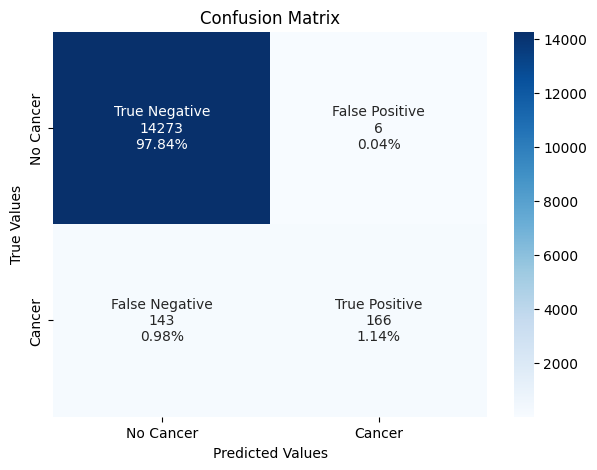

Current Learning Rate: 0.0001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.8, loss=0.000477]


Training metrics for Epoch 4:
Accuracy: 0.9879695640252262
ROC: 0.7417237073491636
Precision: 0.9006024096385542
Recall: 0.4846029173419773
F1 score: 0.6301369863013698
Train loss: 0.0005
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:29<00:00,  5.02batch/s, accuracy=99, loss=0.000394] 


Validation metrics for Epoch 4:
Accuracy: 0.9896490265972032
ROC: 0.7952410934109905
Precision: 0.8798076923076923
Recall: 0.5922330097087378
F1 score: 0.7079303675048355
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.59      0.71       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.94      0.80      0.85     14588
weighted avg       0.99      0.99      0.99     14588



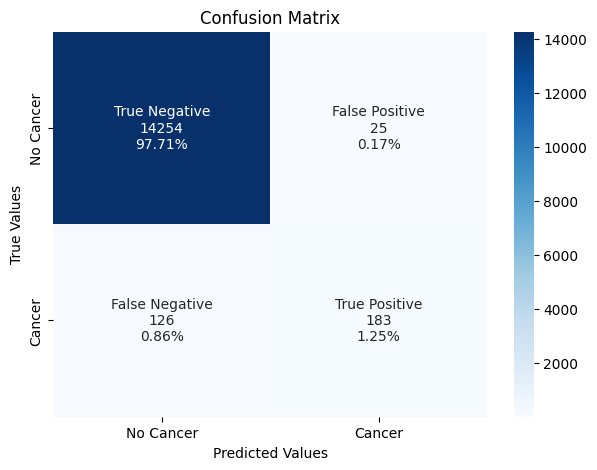

Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99, loss=0.000374]  


Training metrics for Epoch 5:
Accuracy: 0.9904030710172744
ROC: 0.804810230213514
Precision: 0.9040767386091128
Recall: 0.6110210696920584
F1 score: 0.7292069632495164
Train loss: 0.0004
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:28<00:00,  5.10batch/s, accuracy=98.9, loss=0.000426]


Validation metrics for Epoch 5:
Accuracy: 0.9892377296408007
ROC: 0.776033716429246
Precision: 0.9
Recall: 0.5533980582524272
F1 score: 0.6853707414829658
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.55      0.69       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.95      0.78      0.84     14588
weighted avg       0.99      0.99      0.99     14588



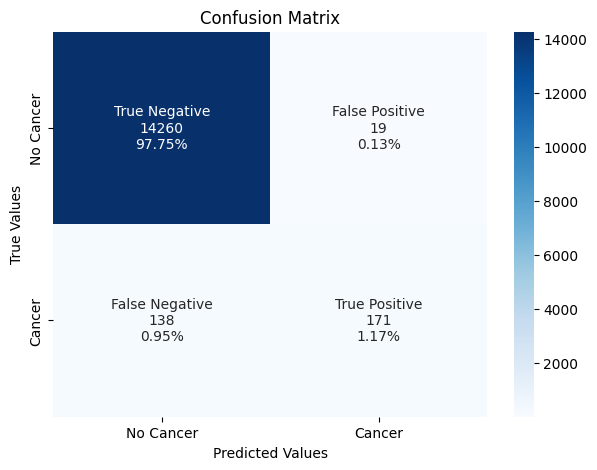

Current Learning Rate: 0.0001
Finished Training


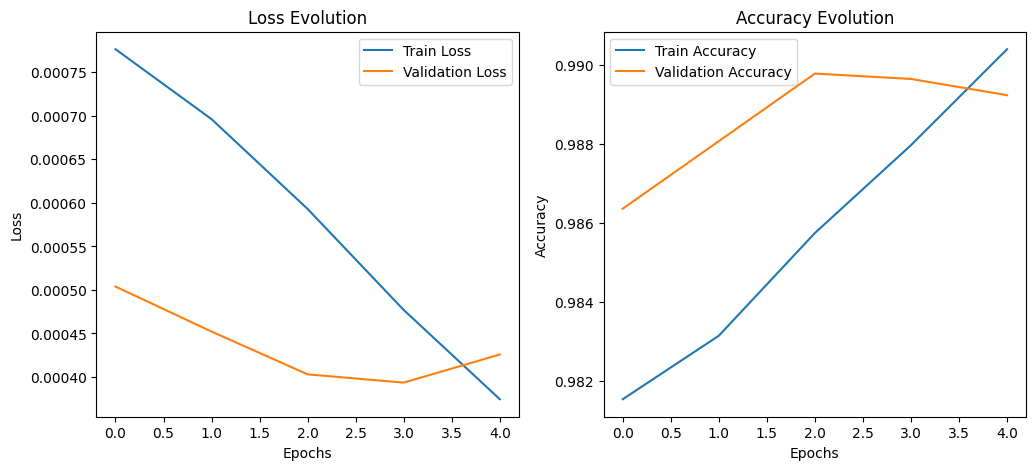

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9892 Precision: 0.9000 Recall: 0.5534 F1: 0.7079 ROC: 0.7760
---------- Fold: 3 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 28559, Validation instances - 14279
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.9, loss=0.000428]


Training metrics for Epoch 1:
Accuracy: 0.9885179599670962
ROC: 0.7745113005843117
Precision: 0.8542713567839196
Recall: 0.5510534846029174
F1 score: 0.6699507389162562
Train loss: 0.0004
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:28<00:00,  5.10batch/s, accuracy=99.9, loss=0.000102]


Validation metrics for Epoch 1:
Accuracy: 0.9985604606525912
ROC: 0.9660194174757282
Precision: 1.0
Recall: 0.9320388349514563
F1 score: 0.9648241206030151
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.93      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       1.00      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



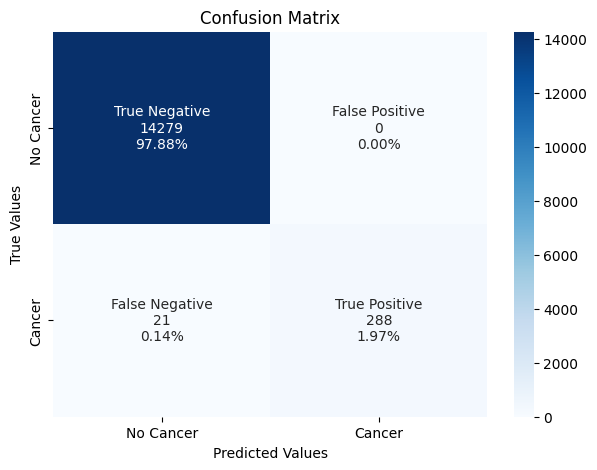

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.2, loss=0.000313]


Training metrics for Epoch 2:
Accuracy: 0.9920139840965176
ROC: 0.8365548292275373
Precision: 0.9285714285714286
Recall: 0.6742301458670988
F1 score: 0.7812206572769953
Train loss: 0.0003
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:28<00:00,  5.13batch/s, accuracy=99.9, loss=8.44e-5]


Validation metrics for Epoch 2:
Accuracy: 0.9985604606525912
ROC: 0.9660194174757282
Precision: 1.0
Recall: 0.9320388349514563
F1 score: 0.9648241206030151
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.93      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       1.00      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



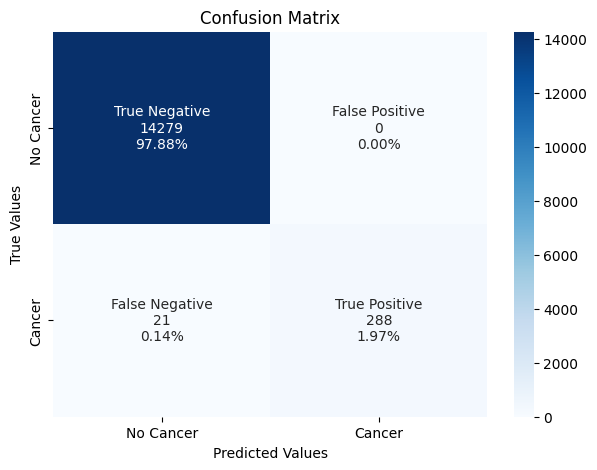

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.5, loss=0.0002]  


Training metrics for Epoch 3:
Accuracy: 0.994995887030436
ROC: 0.8983357436335698
Precision: 0.9590643274853801
Recall: 0.7974068071312804
F1 score: 0.8707964601769912
Train loss: 0.0002
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:28<00:00,  5.11batch/s, accuracy=99.9, loss=7.18e-5]


Validation metrics for Epoch 3:
Accuracy: 0.9985604606525912
ROC: 0.9707687370345617
Precision: 0.9897959183673469
Recall: 0.941747572815534
F1 score: 0.9651741293532338
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.94      0.97       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.99      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



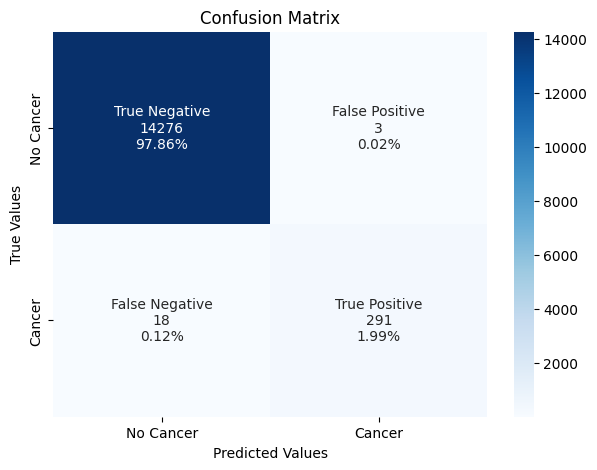

Current Learning Rate: 0.0001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.6, loss=0.000162]


Training metrics for Epoch 4:
Accuracy: 0.9956813819577736
ROC: 0.9145431990630674
Precision: 0.9606003752345216
Recall: 0.8298217179902755
F1 score: 0.8904347826086956
Train loss: 0.0002
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:30<00:00,  4.83batch/s, accuracy=99.8, loss=8.73e-5]


Validation metrics for Epoch 4:
Accuracy: 0.9981491636961887
ROC: 0.9705586382881509
Precision: 0.97
Recall: 0.941747572815534
F1 score: 0.9556650246305418
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.94      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.98      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



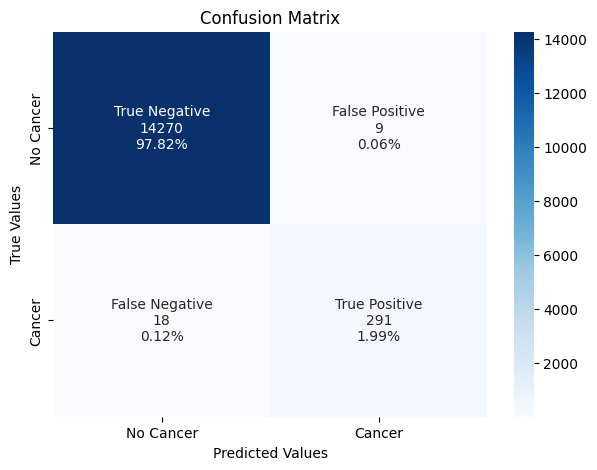

Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.7, loss=0.000112]


Training metrics for Epoch 5:
Accuracy: 0.9967781738415136
ROC: 0.9404751277502634
Precision: 0.9628318584070796
Recall: 0.8816855753646677
F1 score: 0.9204737732656514
Train loss: 0.0001
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:29<00:00,  5.01batch/s, accuracy=99.8, loss=8.47e-5]


Validation metrics for Epoch 5:
Accuracy: 0.9979435152179874
ROC: 0.9593718432776673
Precision: 0.9826989619377162
Recall: 0.919093851132686
F1 score: 0.9498327759197324
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.92      0.95       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.99      0.96      0.97     14588
weighted avg       1.00      1.00      1.00     14588



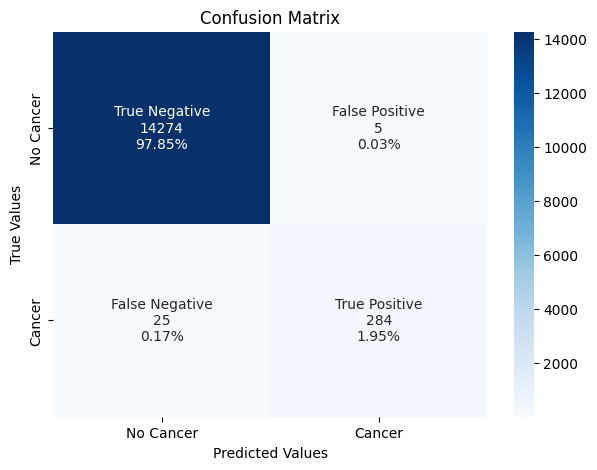

Current Learning Rate: 0.0001
Finished Training


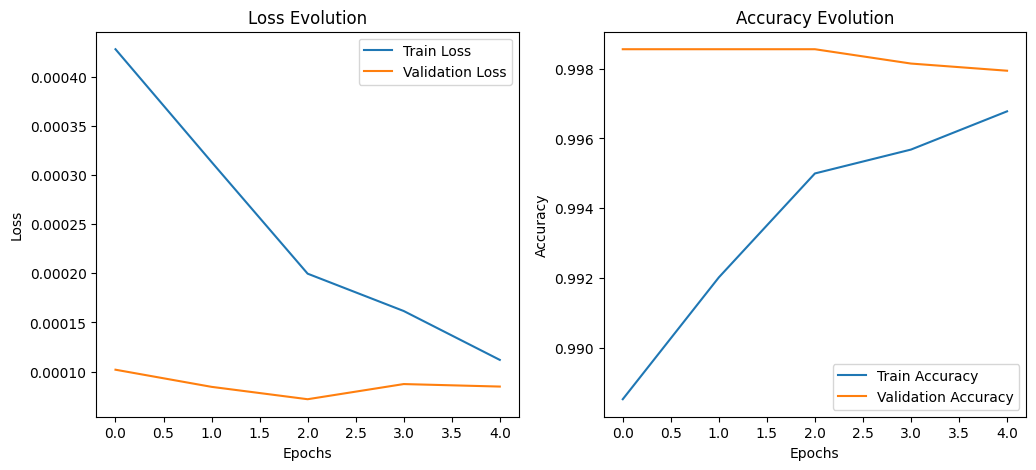

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9979 Precision: 0.9827 Recall: 0.9191 F1: 0.9652 ROC: 0.9594
The overall best model has been saved with metrics - Val Acc: 0.9979, Precision: 0.9827, Recall: 0.9191, F1: 0.9652, ROC: 0.9594
Log file at /kaggle/working/Logs/logs_1.0.0.txt has been closed.


In [34]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 100,  # Taille du batch pour la validation
    "train_batch_size": 100,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '1.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,train_data,hyperparameters)

Shape Of Train Sample: (10942, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,50251,1764774515,1,1,66.0,0,0,No Cancer,/kaggle/working/Processed Image/50251/17647745...
1,17552,2020448477,0,5,77.0,0,0,No Cancer,/kaggle/working/Processed Image/17552/20204484...
2,56125,569514262,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/56125/56951426...
3,59102,1324423486,0,1,46.0,0,0,No Cancer,/kaggle/working/Processed Image/59102/13244234...
4,7420,331414632,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/7420/331414632...


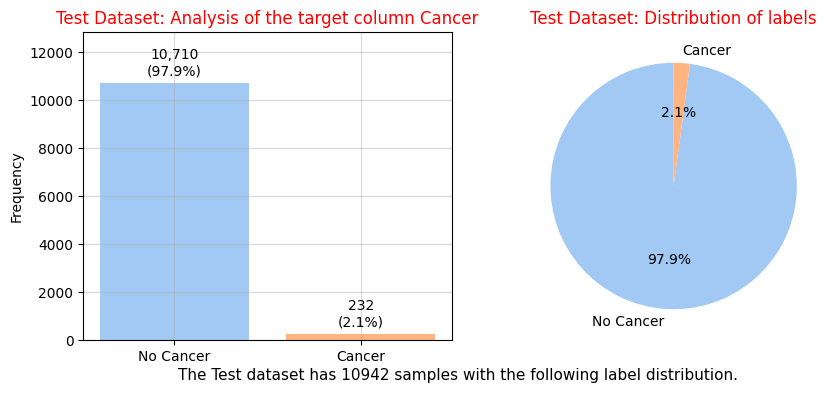

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 365/365 [00:22<00:00, 16.25batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.23      0.03      0.06       232
   No Cancer       0.98      1.00      0.99     10710

    accuracy                           0.98     10942
   macro avg       0.60      0.52      0.52     10942
weighted avg       0.96      0.98      0.97     10942



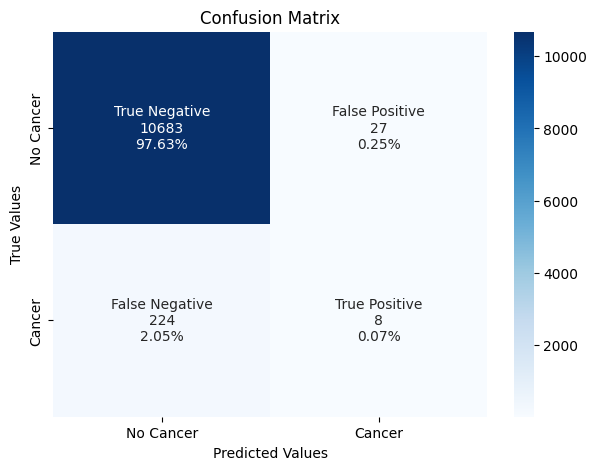

In [35]:
print(f'Shape Of Train Sample: {test_data.shape}')
display(test_data.head())
print("======="*25)
plot_label_distribution(test_data,'Test')
print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3
data_test = test_data.copy()
data_test = test_data.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(data_test,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [36]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 16,  # Taille du batch pour la validation
    "train_batch_size": 16,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 20,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE) # Modèle sur le dispositif approprié

#version = '2.0.0'

#Train_Model_Applying_k_Fold_Cross_Validation(model,processed_df,hyperparameters)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


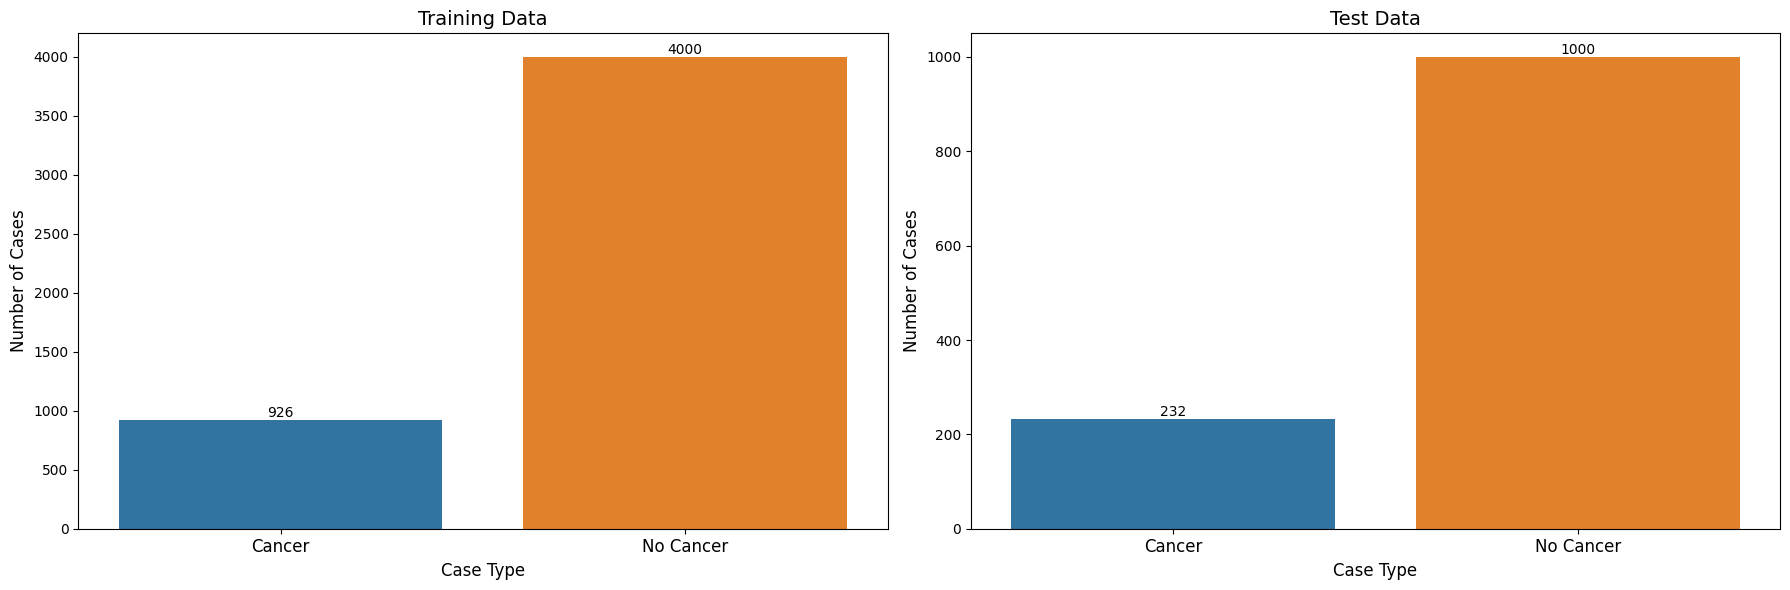

In [41]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 618, Validation instances - 308
Class No Cancer: Training instances - 2666, Validation instances - 1334
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=80, loss=0.00489]  


Training metrics for Epoch 1:
Accuracy: 0.7999390986601705
ROC: 0.5250044307193305
Precision: 0.36363636363636365
Recall: 0.08414239482200647
F1 score: 0.1366622864651774
Train loss: 0.0049
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.74batch/s, accuracy=77, loss=0.00537]  


Validation metrics for Epoch 1:
Accuracy: 0.7704019488428745
ROC: 0.5690287972896668
Precision: 0.3438914027149321
Recall: 0.24675324675324675
F1 score: 0.28733459357277885
Validation Loss: 0.0054
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.34      0.25      0.29       308
   No Cancer       0.84      0.89      0.86      1334

    accuracy                           0.77      1642
   macro avg       0.59      0.57      0.58      1642
weighted avg       0.74      0.77      0.76      1642



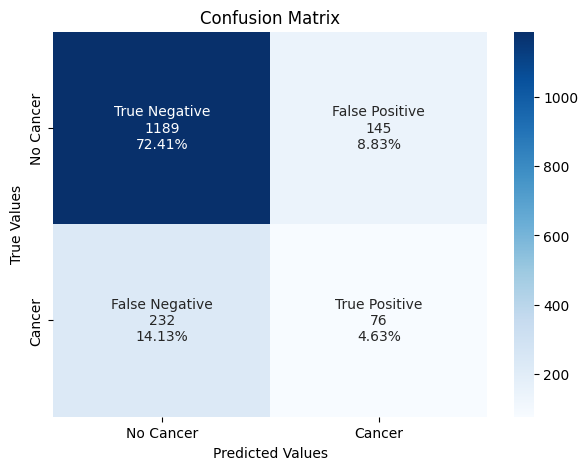

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=83, loss=0.00404]  


Training metrics for Epoch 2:
Accuracy: 0.8297807551766139
ROC: 0.603049427405395
Precision: 0.6244725738396625
Recall: 0.23948220064724918
F1 score: 0.34619883040935673
Train loss: 0.0040
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.79batch/s, accuracy=81.4, loss=0.00603]


Validation metrics for Epoch 2:
Accuracy: 0.8136419001218027
ROC: 0.5069924453357736
Precision: 0.625
Recall: 0.016233766233766232
F1 score: 0.03164556962025316
Validation Loss: 0.0060
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.62      0.02      0.03       308
   No Cancer       0.81      1.00      0.90      1334

    accuracy                           0.81      1642
   macro avg       0.72      0.51      0.46      1642
weighted avg       0.78      0.81      0.73      1642



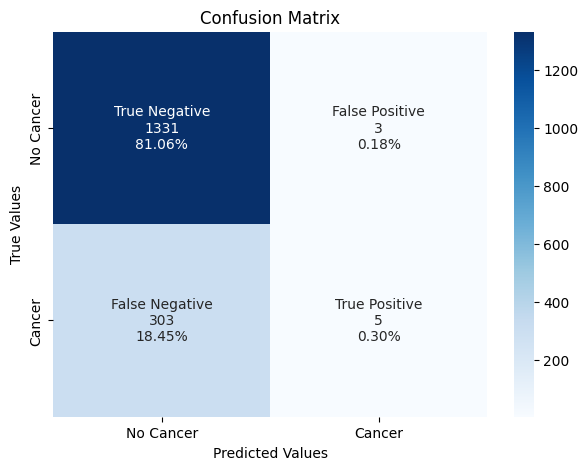

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=87.5, loss=0.00293]


Training metrics for Epoch 3:
Accuracy: 0.8754567600487211
ROC: 0.7213010776966087
Precision: 0.7771883289124668
Recall: 0.4741100323624595
F1 score: 0.5889447236180905
Train loss: 0.0029
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.69batch/s, accuracy=81.9, loss=0.0109]


Validation metrics for Epoch 3:
Accuracy: 0.8191230207064556
ROC: 0.5453255515099593
Precision: 0.6
Recall: 0.10714285714285714
F1 score: 0.18181818181818182
Validation Loss: 0.0109
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.60      0.11      0.18       308
   No Cancer       0.83      0.98      0.90      1334

    accuracy                           0.82      1642
   macro avg       0.71      0.55      0.54      1642
weighted avg       0.78      0.82      0.76      1642



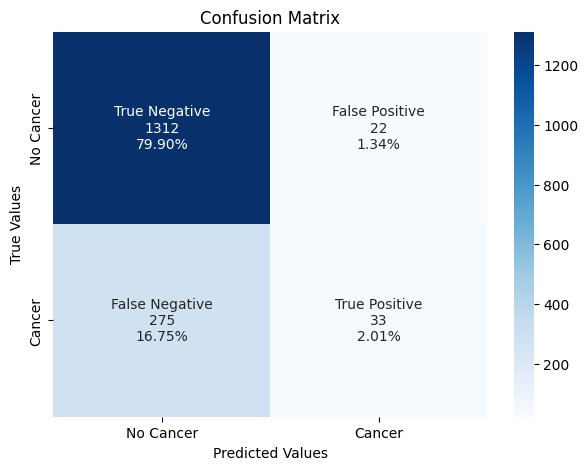

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=92.2, loss=0.00202]


Training metrics for Epoch 4:
Accuracy: 0.9220462850182704
ROC: 0.8494380876772591
Precision: 0.8327205882352942
Recall: 0.7330097087378641
F1 score: 0.7796901893287436
Train loss: 0.0020
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.60batch/s, accuracy=79.2, loss=0.00995]


Validation metrics for Epoch 4:
Accuracy: 0.7917174177831913
ROC: 0.5958814423956853
Precision: 0.4182692307692308
Recall: 0.2824675324675325
F1 score: 0.33720930232558144
Validation Loss: 0.0099
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.42      0.28      0.34       308
   No Cancer       0.85      0.91      0.88      1334

    accuracy                           0.79      1642
   macro avg       0.63      0.60      0.61      1642
weighted avg       0.77      0.79      0.78      1642



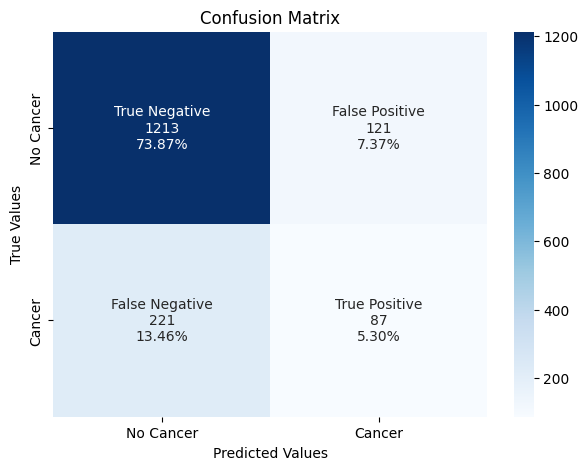

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=95.5, loss=0.00131]


Training metrics for Epoch 5:
Accuracy: 0.9546285018270402
ROC: 0.9186052581106441
Precision: 0.8941176470588236
Recall: 0.86084142394822
F1 score: 0.877164056059357
Train loss: 0.0013
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.87batch/s, accuracy=80.9, loss=0.0191]


Validation metrics for Epoch 5:
Accuracy: 0.8093788063337394
ROC: 0.5131087053875659
Precision: 0.41379310344827586
Recall: 0.03896103896103896
F1 score: 0.0712166172106825
Validation Loss: 0.0191
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.41      0.04      0.07       308
   No Cancer       0.82      0.99      0.89      1334

    accuracy                           0.81      1642
   macro avg       0.62      0.51      0.48      1642
weighted avg       0.74      0.81      0.74      1642



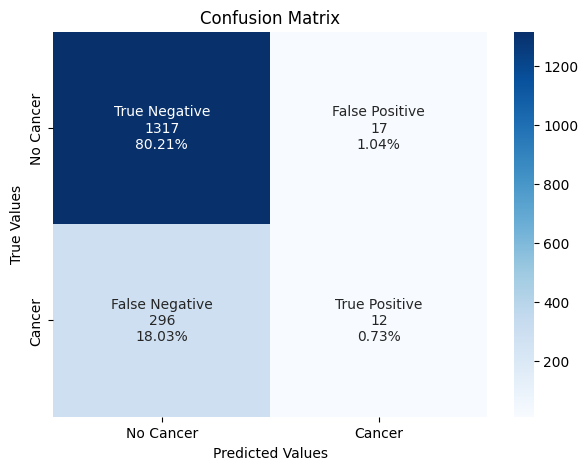

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Finished Training


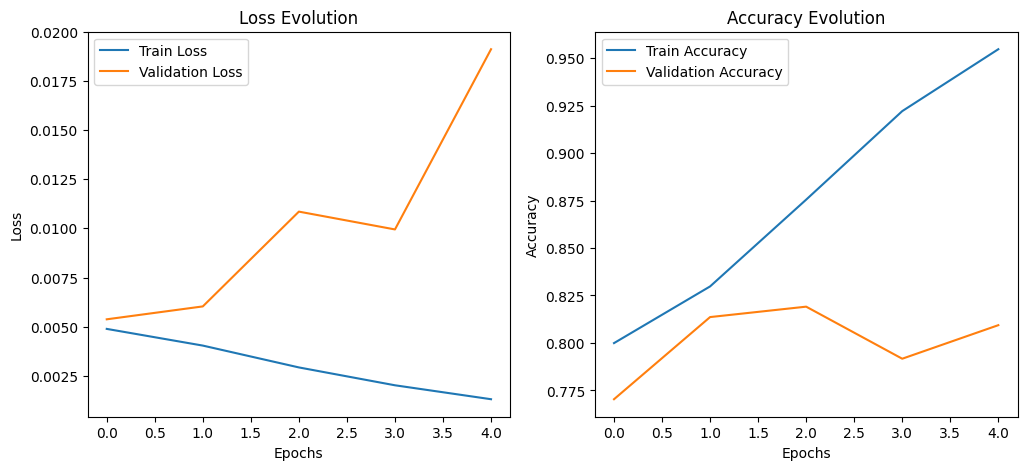

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8094 Precision: 0.4138 Recall: 0.0390 F1: 0.3372 ROC: 0.5131
---------- Fold: 2 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=88.6, loss=0.00388]


Training metrics for Epoch 1:
Accuracy: 0.8858099878197321
ROC: 0.761514312331704
Precision: 0.7676991150442478
Recall: 0.5623987034035657
F1 score: 0.6492048643592143
Train loss: 0.0039
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.78batch/s, accuracy=86.8, loss=0.00445]


Validation metrics for Epoch 1:
Accuracy: 0.8684531059683313
ROC: 0.6579436121166214
Precision: 0.9428571428571428
Recall: 0.32038834951456313
F1 score: 0.47826086956521746
Validation Loss: 0.0044
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.32      0.48       309
   No Cancer       0.86      1.00      0.92      1333

    accuracy                           0.87      1642
   macro avg       0.90      0.66      0.70      1642
weighted avg       0.88      0.87      0.84      1642



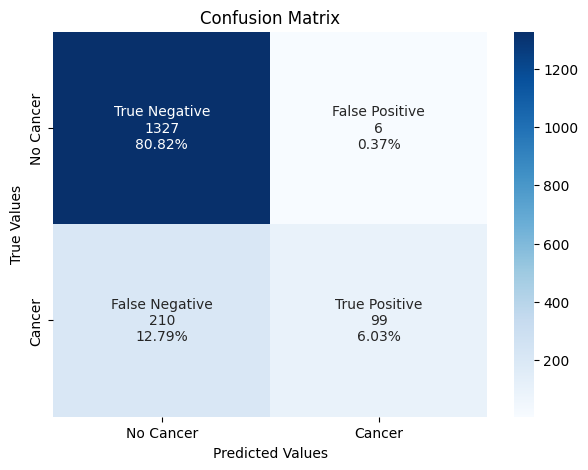

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=92.2, loss=0.00216]


Training metrics for Epoch 2:
Accuracy: 0.9220462850182704
ROC: 0.8211977959805269
Precision: 0.8984547461368654
Recall: 0.6596434359805511
F1 score: 0.7607476635514019
Train loss: 0.0022
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=90.5, loss=0.0025] 


Validation metrics for Epoch 2:
Accuracy: 0.904993909866017
ROC: 0.7513019031456893
Precision: 0.9811320754716981
Recall: 0.5048543689320388
F1 score: 0.6666666666666666
Validation Loss: 0.0025
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.50      0.67       309
   No Cancer       0.90      1.00      0.94      1333

    accuracy                           0.90      1642
   macro avg       0.94      0.75      0.81      1642
weighted avg       0.91      0.90      0.89      1642



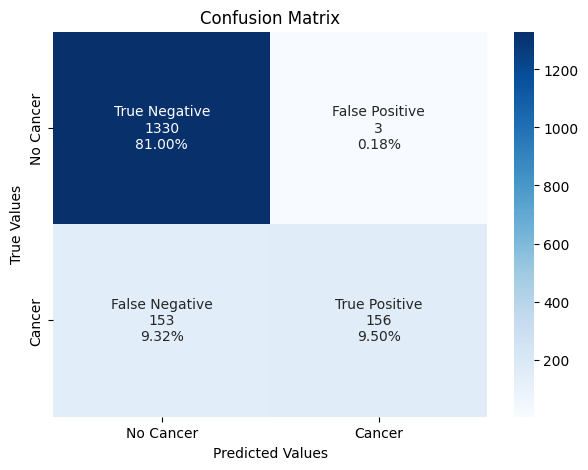

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=94.6, loss=0.00151]


Training metrics for Epoch 3:
Accuracy: 0.9464068209500609
ROC: 0.8773070708138792
Precision: 0.9366336633663367
Recall: 0.766612641815235
F1 score: 0.8431372549019609
Train loss: 0.0015
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.62batch/s, accuracy=92.4, loss=0.00204]


Validation metrics for Epoch 3:
Accuracy: 0.9238733252131547
ROC: 0.8014637154434241
Precision: 0.9842105263157894
Recall: 0.6051779935275081
F1 score: 0.7494989979959921
Validation Loss: 0.0020
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.61      0.75       309
   No Cancer       0.92      1.00      0.96      1333

    accuracy                           0.92      1642
   macro avg       0.95      0.80      0.85      1642
weighted avg       0.93      0.92      0.92      1642



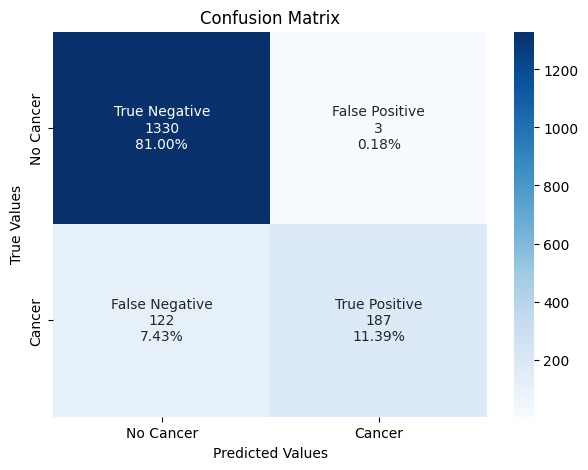

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Current Learning Rate: 1e-05
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96.2, loss=0.00115]


Training metrics for Epoch 4:
Accuracy: 0.9622411693057247
ROC: 0.9157090776942994
Precision: 0.9522935779816514
Recall: 0.8411669367909238
F1 score: 0.8932874354561101
Train loss: 0.0011
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=93.3, loss=0.00181]


Validation metrics for Epoch 4:
Accuracy: 0.9330085261875761
ROC: 0.8244925308997153
Precision: 0.9901477832512315
Recall: 0.6504854368932039
F1 score: 0.7851562500000001
Validation Loss: 0.0018
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.65      0.79       309
   No Cancer       0.92      1.00      0.96      1333

    accuracy                           0.93      1642
   macro avg       0.96      0.82      0.87      1642
weighted avg       0.94      0.93      0.93      1642



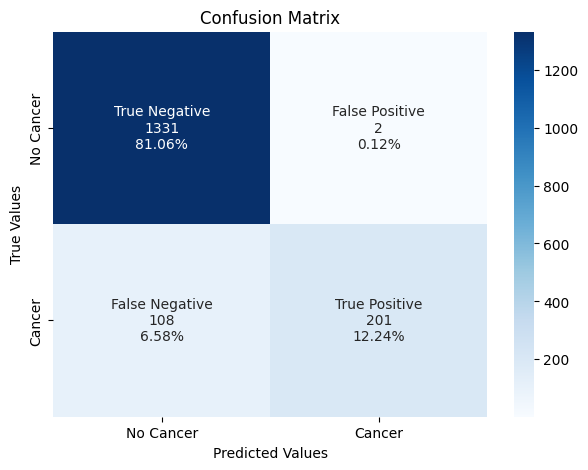

Current Learning Rate: 1e-05
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96.4, loss=0.00113]


Training metrics for Epoch 5:
Accuracy: 0.9643727161997564
ROC: 0.9151527250341682
Precision: 0.9699248120300752
Recall: 0.8363047001620746
F1 score: 0.8981723237597912
Train loss: 0.0011
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.83batch/s, accuracy=93.9, loss=0.00166]


Validation metrics for Epoch 5:
Accuracy: 0.9390986601705238
ROC: 0.840673760673178
Precision: 0.9906103286384976
Recall: 0.6828478964401294
F1 score: 0.8084291187739464
Validation Loss: 0.0017
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.68      0.81       309
   No Cancer       0.93      1.00      0.96      1333

    accuracy                           0.94      1642
   macro avg       0.96      0.84      0.89      1642
weighted avg       0.94      0.94      0.93      1642



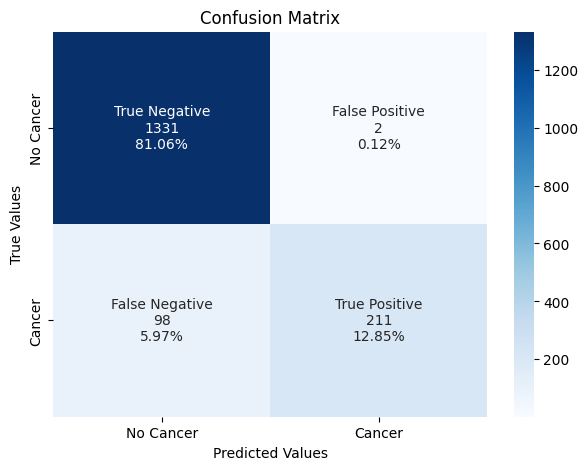

Current Learning Rate: 1e-05
Finished Training


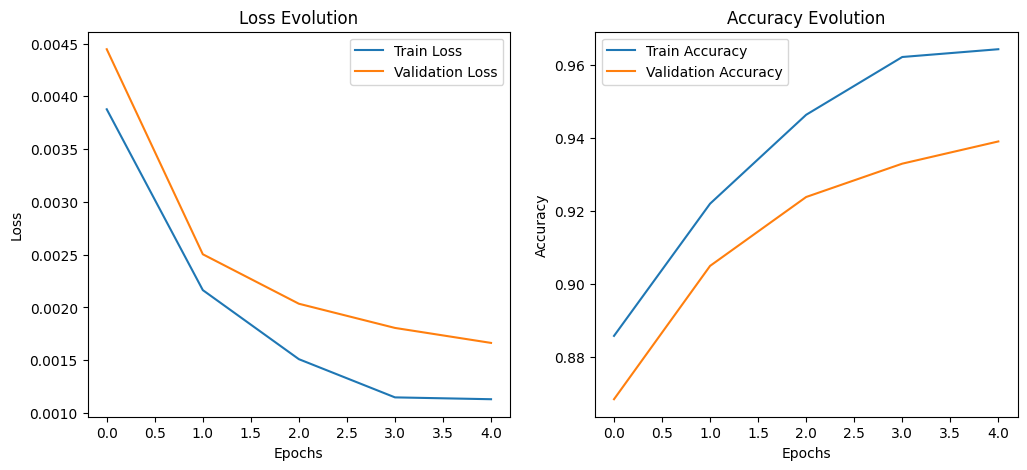

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9391 Precision: 0.9906 Recall: 0.6828 F1: 0.8084 ROC: 0.8407
---------- Fold: 3 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=95.2, loss=0.00131]


Training metrics for Epoch 1:
Accuracy: 0.9521924482338612
ROC: 0.8945728420900385
Precision: 0.9339622641509434
Recall: 0.8022690437601296
F1 score: 0.8631211857018307
Train loss: 0.0013
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.67batch/s, accuracy=95.4, loss=0.00123]


Validation metrics for Epoch 1:
Accuracy: 0.9543239951278928
ROC: 0.8836128935146408
Precision: 0.9834710743801653
Recall: 0.7702265372168284
F1 score: 0.8638838475499092
Validation Loss: 0.0012
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.77      0.86       309
   No Cancer       0.95      1.00      0.97      1333

    accuracy                           0.95      1642
   macro avg       0.97      0.88      0.92      1642
weighted avg       0.96      0.95      0.95      1642



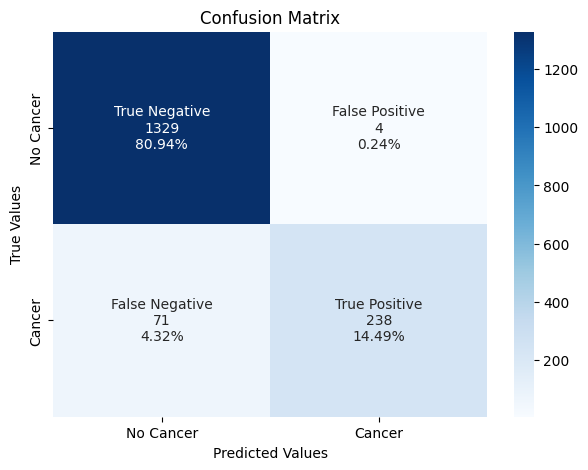

Epoch 00011: reducing learning rate of group 0 to 1.0000e-06.
Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96, loss=0.00118]  


Training metrics for Epoch 2:
Accuracy: 0.9604141291108405
ROC: 0.908355256241268
Precision: 0.9585687382297552
Recall: 0.8249594813614263
F1 score: 0.8867595818815331
Train loss: 0.0012
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.73batch/s, accuracy=95.8, loss=0.0011] 


Validation metrics for Epoch 2:
Accuracy: 0.9579780755176613
ROC: 0.8933216313787185
Precision: 0.9838709677419355
Recall: 0.7896440129449838
F1 score: 0.8761220825852782
Validation Loss: 0.0011
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.79      0.88       309
   No Cancer       0.95      1.00      0.97      1333

    accuracy                           0.96      1642
   macro avg       0.97      0.89      0.93      1642
weighted avg       0.96      0.96      0.96      1642



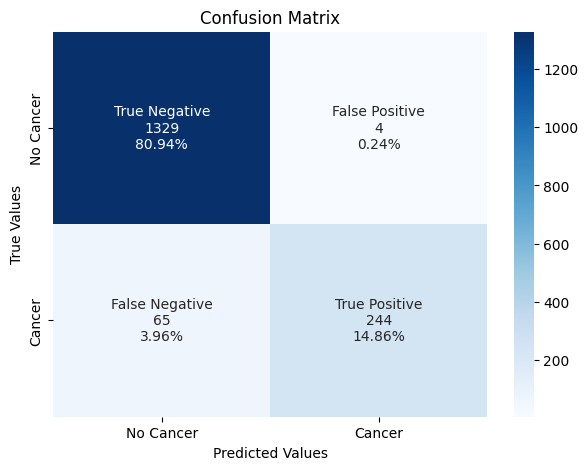

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.3, loss=0.00117]


Training metrics for Epoch 3:
Accuracy: 0.9634591961023142
ROC: 0.9177047763681081
Precision: 0.9559633027522936
Recall: 0.8444084278768234
F1 score: 0.8967297762478486
Train loss: 0.0012
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=96.2, loss=0.000984]


Validation metrics for Epoch 3:
Accuracy: 0.9622411693057247
ROC: 0.9046484922201424
Precision: 0.984313725490196
Recall: 0.8122977346278317
F1 score: 0.8900709219858157
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.81      0.89       309
   No Cancer       0.96      1.00      0.98      1333

    accuracy                           0.96      1642
   macro avg       0.97      0.90      0.93      1642
weighted avg       0.96      0.96      0.96      1642



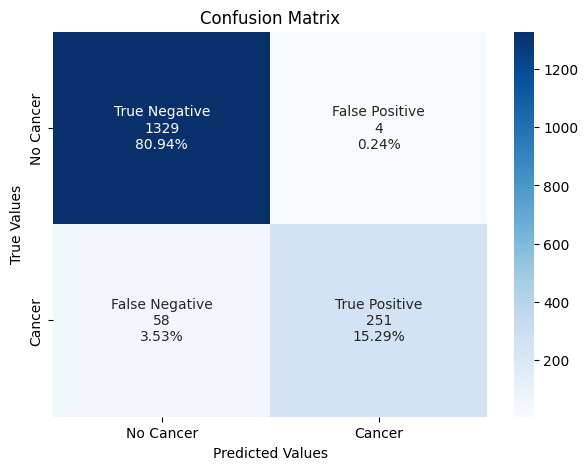

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.3, loss=0.00115]


Training metrics for Epoch 4:
Accuracy: 0.9631546894031668
ROC: 0.9200088846268609
Precision: 0.9476534296028881
Recall: 0.8508914100486223
F1 score: 0.8966695132365499
Train loss: 0.0012
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.76batch/s, accuracy=96.7, loss=0.000876]


Validation metrics for Epoch 4:
Accuracy: 0.9671132764920828
ROC: 0.9163504468350098
Precision: 0.9885057471264368
Recall: 0.8349514563106796
F1 score: 0.9052631578947368
Validation Loss: 0.0009
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.83      0.91       309
   No Cancer       0.96      1.00      0.98      1333

    accuracy                           0.97      1642
   macro avg       0.98      0.92      0.94      1642
weighted avg       0.97      0.97      0.97      1642



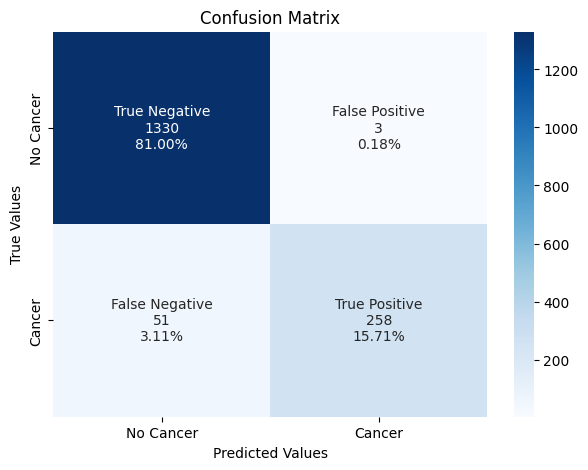

Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.
Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.1, loss=0.00112]


Training metrics for Epoch 5:
Accuracy: 0.9610231425091352
ROC: 0.9137133790204911
Precision: 0.9486238532110092
Recall: 0.8379254457050244
F1 score: 0.8898450946643718
Train loss: 0.0011
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.49batch/s, accuracy=97.2, loss=0.000792]


Validation metrics for Epoch 5:
Accuracy: 0.9719853836784409
ROC: 0.928052401449877
Precision: 0.9925093632958801
Recall: 0.8576051779935275
F1 score: 0.920138888888889
Validation Loss: 0.0008
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.86      0.92       309
   No Cancer       0.97      1.00      0.98      1333

    accuracy                           0.97      1642
   macro avg       0.98      0.93      0.95      1642
weighted avg       0.97      0.97      0.97      1642



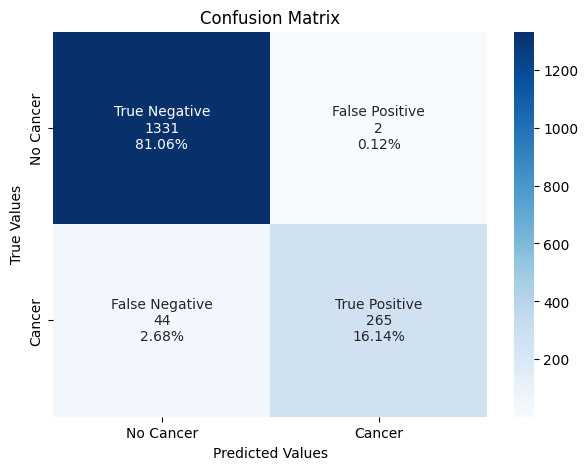

Current Learning Rate: 1.0000000000000002e-07
Finished Training


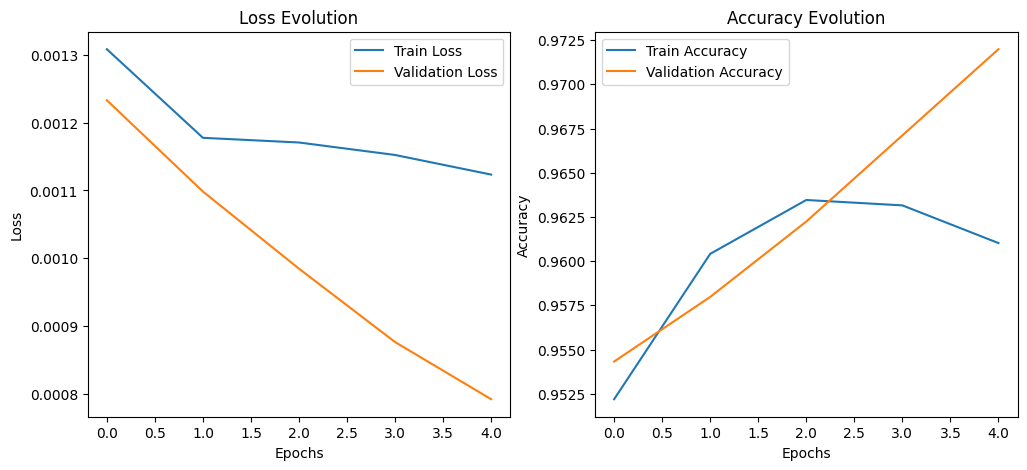

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9720 Precision: 0.9925 Recall: 0.8576 F1: 0.9201 ROC: 0.9281
The overall best model has been saved with metrics - Val Acc: 0.9720, Precision: 0.9925, Recall: 0.8576, F1: 0.9201, ROC: 0.9281
Log file at /kaggle/working/Logs/logs_2.0.0.txt has been closed.


In [43]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 100,  # Taille du batch pour la validation
    "train_batch_size": 100,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '2.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,train_data,hyperparameters)

Shape Of Train Sample: (1232, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,35054,387610162,1,1,63.0,0,0,No Cancer,/kaggle/working/Processed Image/35054/38761016...
1,39613,624810260,1,1,54.0,0,0,No Cancer,/kaggle/working/Processed Image/39613/62481026...
2,42214,1530070466,1,5,71.0,0,0,No Cancer,/kaggle/working/Processed Image/42214/15300704...
3,37590,567820212,1,1,54.0,0,0,No Cancer,/kaggle/working/Processed Image/37590/56782021...
4,63976,1245634911,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/63976/12456349...


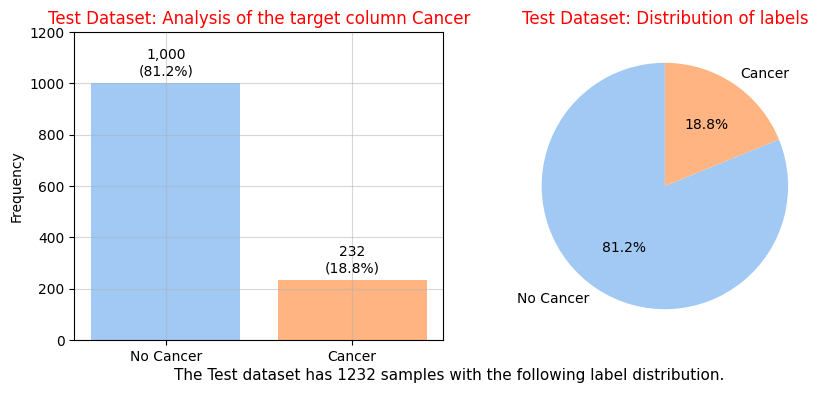

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 42/42 [00:02<00:00, 14.52batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.45      0.12      0.20       232
   No Cancer       0.83      0.96      0.89      1000

    accuracy                           0.81      1232
   macro avg       0.64      0.54      0.54      1232
weighted avg       0.75      0.81      0.76      1232



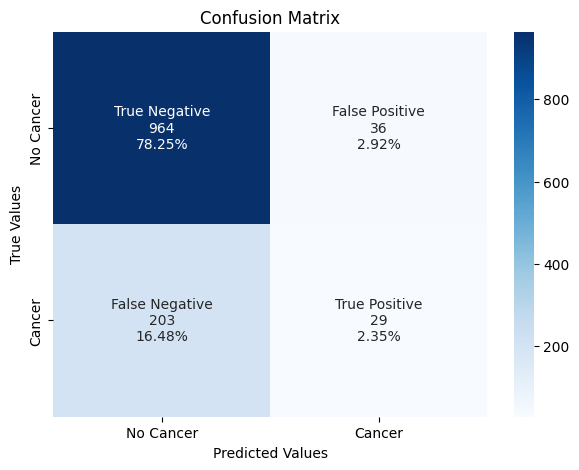

In [44]:
print(f'Shape Of Train Sample: {test_data.shape}') #test_data
display(test_data.head())
print("======="*25)
plot_label_distribution(test_data,'Test')
print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3
data_test = test_data.copy()
data_test = test_data.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(data_test,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [47]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 3 -------------------------------------------------------------------------------------" + Color.E)
# Fonction pour générer l'ID de l'image traitée
def generate_image_processed_id(image_id, index):
    return f"{image_id}_aug_{index}"

# Fonction pour appliquer les transformations et sauvegarder les images transformées
def apply_transformations_and_save(path_cancer: str, path_no_cancer: str, Width: int, Height: int, num_images_cancer: int, dataset: pd.DataFrame, transformations_cancer):
    resize_transform = A.Resize(width=Width, height=Height)

    # Initialiser les compteurs
    num_rejected,num_accepted,num_cancer,num_no_cancer = 0,0,0,0

    processed_data = []

    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        image_path,image_id,is_cancer = row['path_image_processed'],row['image_id'],row['cancer']

        # Lire l'image avec OpenCV et convertir en RGB
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read image {image_path}. Skipping.")
            num_rejected += 1
            continue

        # Redimensionner l'image
        image_resized = resize_transform(image=image)['image']
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR)
        image_resized_id = f"{image_id}_resized"
        if is_cancer == 0:
            save_folder = path_no_cancer
            num_no_cancer += 1
        else:
            save_folder = path_cancer
            num_cancer += 1
        save_path_resized = os.path.join(save_folder, f"{image_resized_id}.png")
        cv2.imwrite(save_path_resized, image_resized)

        processed_data.append({
            'patient_id': row['patient_id'],'image_id': image_id,'image_processed_id': image_resized_id,
            'laterality': row['laterality'],'view': row['view'],'age': row['age'],'cancer': is_cancer,
            'labels': row['labels'],'implant': row['implant'],'path_img_aug': save_path_resized
            })

        if is_cancer == 1: 
            transformations = transformations_cancer
            num_processed = num_images_cancer
            #print("Image to process:",num_processed)
            for i in range(num_processed):
                transformed = transformations[i](image=image_resized)['image']
                transformed = cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR)
                image_processed_id = generate_image_processed_id(image_id, i)
                save_path = os.path.join(save_folder, f"{image_processed_id}.png")
                cv2.imwrite(save_path, transformed)
                processed_data.append({
                    'patient_id': row['patient_id'],
                    'image_id': image_id,
                    'image_processed_id': image_processed_id,
                    'laterality': row['laterality'],
                    'view': row['view'],
                    'age': row['age'],
                    'cancer': is_cancer,
                    'labels': row['labels'],
                    'implant': row['implant'],
                    'path_img_aug': save_path
                })
                num_cancer += 1
        #print("Len Image to process:",len(processed_data))
        num_accepted += 1

    print(f"Images rejectd: {num_rejected}")
    print(f"Images accepted: {num_accepted}")
    print(f"Images generated for cancer class: {num_cancer}")
    print(f"Images generated for no cancer class: {num_no_cancer}")

    processed_df = pd.DataFrame(processed_data)

    return processed_df


# Function to manage directories
def manage_directories(create_dirs: bool):
    base_dir = '/kaggle/working/data_augmentation_image'
    cancer_dir = os.path.join(base_dir, 'cancer')
    no_cancer_dir = os.path.join(base_dir, 'no_cancer')
    
    if create_dirs:
        if os.path.exists(base_dir):
            print(f"Base directory '{base_dir}' already exists. Removing it.")
            shutil.rmtree(base_dir)
            print(f"Base directory '{base_dir}' has been removed.")
        
        print(f"Creating directories '{cancer_dir}' and '{no_cancer_dir}'.")
        os.makedirs(cancer_dir)
        os.makedirs(no_cancer_dir)
        print(f"Directories '{cancer_dir}' and '{no_cancer_dir}' have been created.")
        
    else:
        if not os.path.exists(base_dir):
            print(f"Base directory '{base_dir}' does not exist. Creating it along with subdirectories.")
            os.makedirs(cancer_dir)
            os.makedirs(no_cancer_dir)
            print(f"Directories '{cancer_dir}' and '{no_cancer_dir}' have been created.")
        else:
            print(f"Base directory '{base_dir}' already exists. No action taken.")

---------------------------------------------------------------------------------------------------------- Modèle 3 -------------------------------------------------------------------------------------


In [48]:
manage_directories(create_dirs=True)

Base directory '/kaggle/working/data_augmentation_image' already exists. Removing it.
Base directory '/kaggle/working/data_augmentation_image' has been removed.
Creating directories '/kaggle/working/data_augmentation_image/cancer' and '/kaggle/working/data_augmentation_image/no_cancer'.
Directories '/kaggle/working/data_augmentation_image/cancer' and '/kaggle/working/data_augmentation_image/no_cancer' have been created.


Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


100%|██████████| 4926/4926 [00:31<00:00, 154.17it/s]


Images rejectd: 0
Images accepted: 4926
Images generated for cancer class: 3704
Images generated for no cancer class: 4000


,patient_id,image_id,image_processed_id,laterality,view,age,cancer,labels,implant,path_img_aug
0,61227,1640910603,1640910603_resized,1,1,52.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
1,13756,1628769232,1628769232_resized,1,1,71.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
2,2266,329697695,329697695_resized,1,1,64.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
3,17679,664449220,664449220_resized,1,1,68.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
4,56308,1609200371,1609200371_resized,0,5,60.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
...,...,...,...,...,...,...,...,...,...,...
7699,6107,1557292062,1557292062_resized,1,1,58.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
7700,62996,1386866094,1386866094_resized,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
7701,62996,1386866094,1386866094_aug_0,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
7702,62996,1386866094,1386866094_aug_1,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...


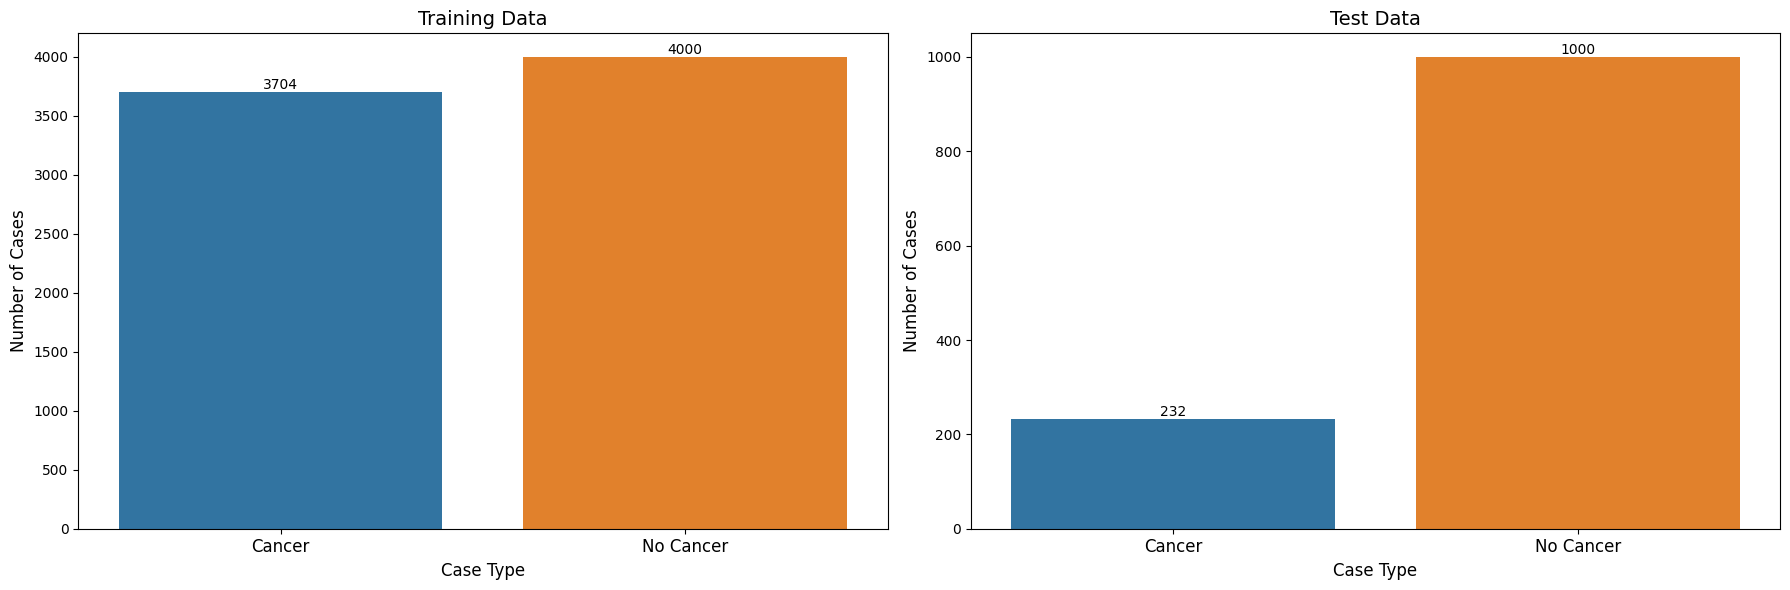

In [59]:
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

Width, Height = 224, 224

# Define simple transformations for testing
transformations_cancer = [
    A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89), A.RandomRotate90(p=1), A.Transpose(p=1)]),
    A.Compose([A.Resize(Width, Height), A.Rotate(limit=90, p=0.8), A.Perspective(scale=(0.05, 0.1), p=0.5)]),
    A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5), A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)]),
    #A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89)]),
    #A.Compose([A.RandomCrop(width=200, height=200),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2),A.Resize(Width, Height)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.3), A.Transpose(p=0.8)]),
    #A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    #A.Compose([A.Resize(Width, Height), A.RandomCrop(height=200, width=200, p=0.5), A.Resize(Width, Height, p=1.0)]),
    #A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    #A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    #A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    #A.Compose([A.RandomCrop(width=150, height=200),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3),A.Resize(Width, Height)])
]

# Test the function
processed_df = apply_transformations_and_save(
    '/kaggle/working/data_augmentation_image/cancer',
    '/kaggle/working/data_augmentation_image/no_cancer',
    Width=Width, 
    Height=Height, 
    num_images_cancer=len(transformations_cancer), 
    dataset=train_data, 
    transformations_cancer=transformations_cancer)

# Display the processed DataFrame
display(processed_df)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(processed_df, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [61]:
class My_Custom_RSNA_Dataset(Dataset): 
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_img_aug'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}

In [62]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 250,  # Taille du batch pour la validation
    "train_batch_size": 200,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '3.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,processed_df,hyperparameters)

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (5136, 10)
Dimensions of valid_data: (2568, 10)
Class Cancer: Training instances - 2470, Validation instances - 1234
Class No Cancer: Training instances - 2666, Validation instances - 1334
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training:   0%|          | 0/26 [00:01<?, ?batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 174.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 75.12 MiB is free. Process 4358 has 15.81 GiB memory in use. Of the allocated memory 15.25 GiB is allocated by PyTorch, and 250.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

class OptimizedEffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(
            nn.Linear(self.no_columns, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        # Define Classification part
        self.classification = nn.Sequential(
            nn.Linear(1408 + 256, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, self.output_size)
        )
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.adaptive_avg_pool2d(image, 1).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data shape:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data shape:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Output shape:', out.shape)
        
        return out

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=74.2, loss=0.00603]


Training metrics for Epoch 1:
Accuracy: 0.7419898819561551
ROC: 0.7485225659948906
Precision: 0.8216783216783217
Recall: 0.6670451319897814
F1 score: 0.7363308788970703
Train loss: 0.0060
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.85batch/s, accuracy=73.6, loss=0.0181]


Validation metrics for Epoch 1:
Accuracy: 0.7357449417535254
ROC: 0.7501872871736662
Precision: 0.9054054054054054
Recall: 0.5703745743473326
F1 score: 0.6998607242339833
Validation Loss: 0.0181
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.57      0.70      1762
   No Cancer       0.65      0.93      0.76      1500

    accuracy                           0.74      3262
   macro avg       0.78      0.75      0.73      3262
weighted avg       0.79      0.74      0.73      3262



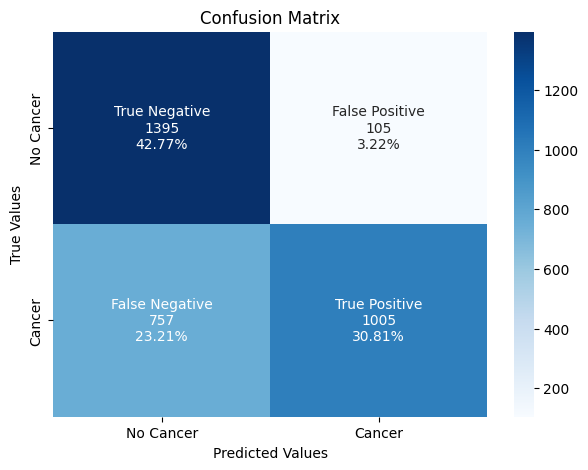

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=80.6, loss=0.00498]


Training metrics for Epoch 2:
Accuracy: 0.8057642189176759
ROC: 0.8117198410445643
Precision: 0.8836734693877552
Recall: 0.7374396820891286
F1 score: 0.8039610088194337
Train loss: 0.0050
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.98batch/s, accuracy=80, loss=0.0171] 


Validation metrics for Epoch 2:
Accuracy: 0.7998160637645616
ROC: 0.8061740446462353
Precision: 0.8816242257398486
Recall: 0.7270147559591373
F1 score: 0.7968895800933126
Validation Loss: 0.0171
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.73      0.80      1762
   No Cancer       0.73      0.89      0.80      1500

    accuracy                           0.80      3262
   macro avg       0.81      0.81      0.80      3262
weighted avg       0.81      0.80      0.80      3262



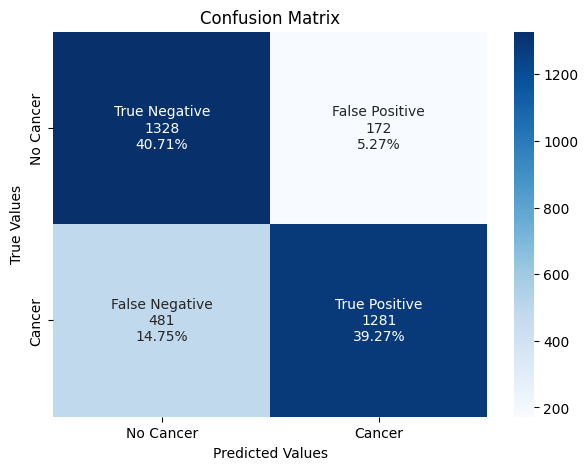

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=84.3, loss=0.0043] 


Training metrics for Epoch 3:
Accuracy: 0.8434769277939599
ROC: 0.8472023370233702
Precision: 0.8984076433121019
Recall: 0.8007380073800738
F1 score: 0.8467657211466305
Train loss: 0.0043
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.95batch/s, accuracy=67.6, loss=0.0508]


Validation metrics for Epoch 3:
Accuracy: 0.6759656652360515
ROC: 0.657579644343549
Precision: 0.645721372467962
Recall: 0.8864926220204313
F1 score: 0.7471896675436498
Validation Loss: 0.0508
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.65      0.89      0.75      1762
   No Cancer       0.76      0.43      0.55      1500

    accuracy                           0.68      3262
   macro avg       0.70      0.66      0.65      3262
weighted avg       0.70      0.68      0.66      3262



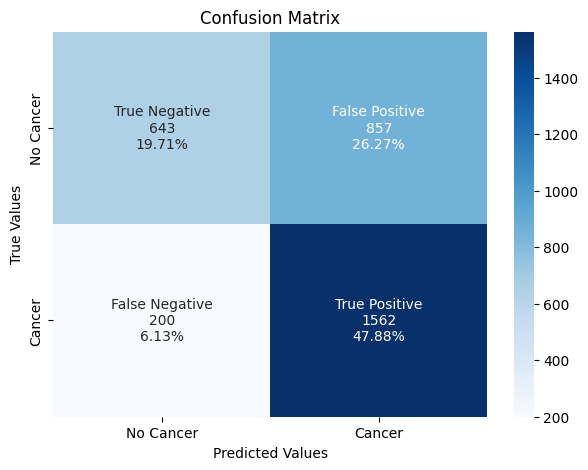

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=86.7, loss=0.00355]


Training metrics for Epoch 4:
Accuracy: 0.866932393070673
ROC: 0.8696590500520388
Precision: 0.9106093411691927
Recall: 0.8356514334374113
F1 score: 0.871521610420367
Train loss: 0.0036
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 14.94batch/s, accuracy=80.5, loss=0.0204]


Validation metrics for Epoch 4:
Accuracy: 0.8050275904353158
ROC: 0.812683314415437
Precision: 0.9015691868758916
Recall: 0.717366628830874
F1 score: 0.7989886219974716
Validation Loss: 0.0204
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.72      0.80      1762
   No Cancer       0.73      0.91      0.81      1500

    accuracy                           0.81      3262
   macro avg       0.82      0.81      0.80      3262
weighted avg       0.82      0.81      0.80      3262



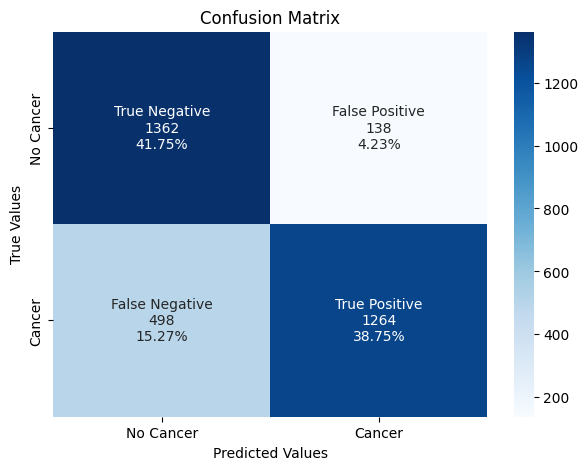

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=89, loss=0.00324]  


Training metrics for Epoch 5:
Accuracy: 0.8899279472635291
ROC: 0.8916899895922035
Precision: 0.9220583809810412
Recall: 0.8697133125177405
F1 score: 0.8951212386795209
Train loss: 0.0032
Validating the trained model's performance


Validation 5: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=81.1, loss=0.0158]


Validation metrics for Epoch 5:
Accuracy: 0.8108522378908645
ROC: 0.8111853953840333
Precision: 0.836962919364332
Recall: 0.8070374574347332
F1 score: 0.8217278243282288
Validation Loss: 0.0158
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.84      0.81      0.82      1762
   No Cancer       0.78      0.82      0.80      1500

    accuracy                           0.81      3262
   macro avg       0.81      0.81      0.81      3262
weighted avg       0.81      0.81      0.81      3262



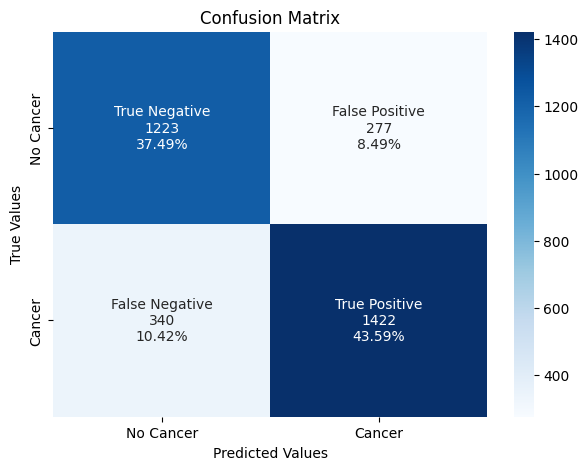

Current Learning Rate: 0.001
Training the model


Epoch 6, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00227]


Training metrics for Epoch 6:
Accuracy: 0.9293269967806224
ROC: 0.9296985996783045
Precision: 0.9429976851851852
Recall: 0.9250638660232756
F1 score: 0.9339446912165067
Train loss: 0.0023
Validating the trained model's performance


Validation 6: 100%|██████████| 102/102 [00:06<00:00, 14.89batch/s, accuracy=83.1, loss=0.0169]


Validation metrics for Epoch 6:
Accuracy: 0.8307786633966892
ROC: 0.8391963677639046
Precision: 0.9390420899854862
Recall: 0.7343927355278093
F1 score: 0.824203821656051
Validation Loss: 0.0169
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.73      0.82      1762
   No Cancer       0.75      0.94      0.84      1500

    accuracy                           0.83      3262
   macro avg       0.85      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



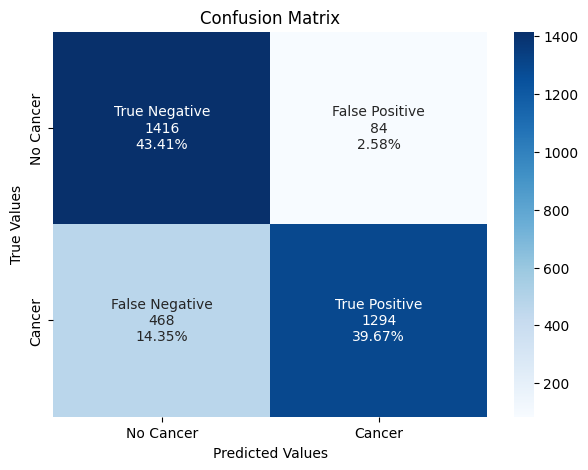

Current Learning Rate: 0.001
Training the model


Epoch 7, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=94.9, loss=0.00163]


Training metrics for Epoch 7:
Accuracy: 0.9494097807757167
ROC: 0.9497010123947394
Precision: 0.9596890296573568
Recall: 0.9460686914561454
F1 score: 0.9528301886792453
Train loss: 0.0016
Validating the trained model's performance


Validation 7: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=83.3, loss=0.016]


Validation metrics for Epoch 7:
Accuracy: 0.8326180257510729
ROC: 0.8388172531214528
Precision: 0.9141689373297003
Recall: 0.7616345062429057
F1 score: 0.8309597523219814
Validation Loss: 0.0160
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.76      0.83      1762
   No Cancer       0.77      0.92      0.83      1500

    accuracy                           0.83      3262
   macro avg       0.84      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



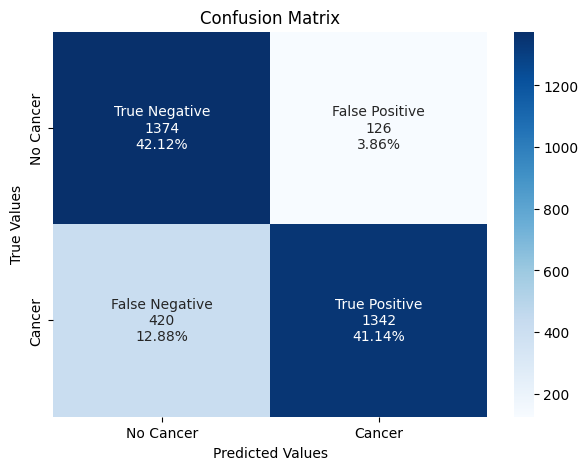

Current Learning Rate: 0.001
Training the model


Epoch 8, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=95.6, loss=0.0015] 


Training metrics for Epoch 8:
Accuracy: 0.9560018396443354
ROC: 0.9561996404579431
Precision: 0.9644087256027555
Recall: 0.9537326142492194
F1 score: 0.959040959040959
Train loss: 0.0015
Validating the trained model's performance


Validation 8: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=75.2, loss=0.0519]


Validation metrics for Epoch 8:
Accuracy: 0.7522992029429798
ROC: 0.7389440030268635
Precision: 0.7133273703041145
Recall: 0.9052213393870602
F1 score: 0.7978989494747374
Validation Loss: 0.0519
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.71      0.91      0.80      1762
   No Cancer       0.84      0.57      0.68      1500

    accuracy                           0.75      3262
   macro avg       0.78      0.74      0.74      3262
weighted avg       0.77      0.75      0.74      3262



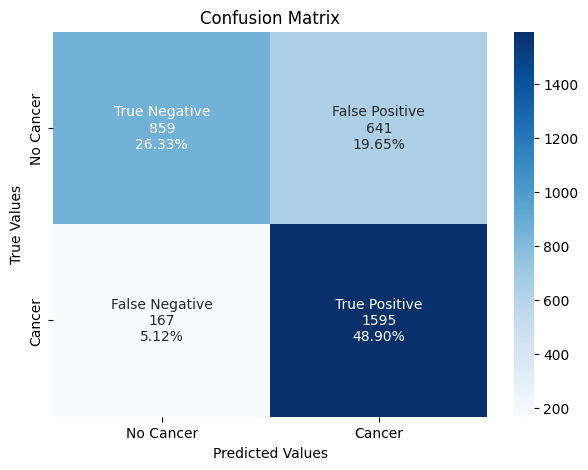

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Training the model


Epoch 9, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=97.9, loss=0.000797]


Training metrics for Epoch 9:
Accuracy: 0.9791506975318105
ROC: 0.979411675655218
Precision: 0.9851045545688915
Recall: 0.9761566846437695
F1 score: 0.9806102081551183
Train loss: 0.0008
Validating the trained model's performance


Validation 9: 100%|██████████| 102/102 [00:06<00:00, 14.97batch/s, accuracy=73.6, loss=0.0509]


Validation metrics for Epoch 9:
Accuracy: 0.7357449417535254
ROC: 0.7165327279606508
Precision: 0.6823338735818476
Recall: 0.9557321225879682
F1 score: 0.7962174940898346
Validation Loss: 0.0509
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.68      0.96      0.80      1762
   No Cancer       0.90      0.48      0.62      1500

    accuracy                           0.74      3262
   macro avg       0.79      0.72      0.71      3262
weighted avg       0.78      0.74      0.72      3262



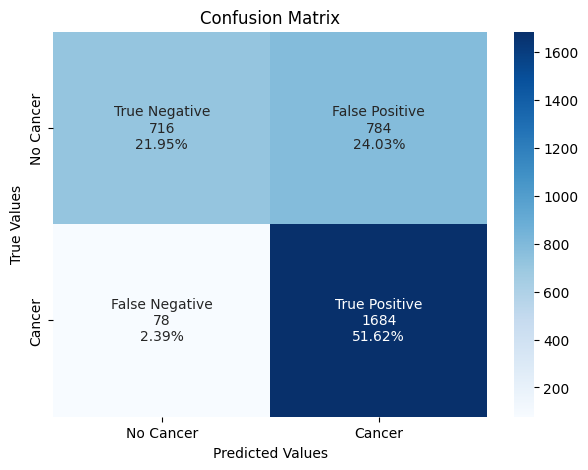

Current Learning Rate: 0.0001
Training the model


Epoch 10, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.4, loss=0.000269]


Training metrics for Epoch 10:
Accuracy: 0.9943277632990956
ROC: 0.9943776610843031
Precision: 0.9957337883959044
Recall: 0.9937553221686063
F1 score: 0.9947435715300469
Train loss: 0.0003
Validating the trained model's performance


Validation 10: 100%|██████████| 102/102 [00:06<00:00, 15.02batch/s, accuracy=86.5, loss=0.0175]


Validation metrics for Epoch 10:
Accuracy: 0.8654199877375843
ROC: 0.8654631101021567
Precision: 0.8834782608695653
Recall: 0.8649262202043133
F1 score: 0.8741038141669056
Validation Loss: 0.0175
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.86      0.87      1762
   No Cancer       0.85      0.87      0.86      1500

    accuracy                           0.87      3262
   macro avg       0.86      0.87      0.86      3262
weighted avg       0.87      0.87      0.87      3262



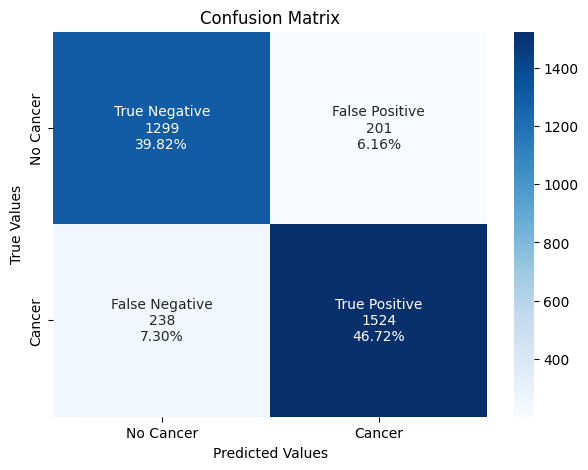

Current Learning Rate: 0.0001
Finished Training


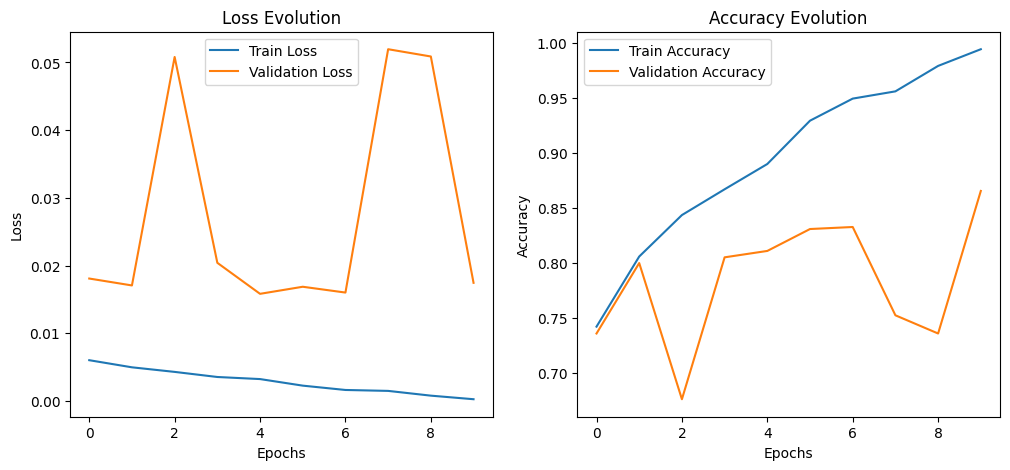

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8654 Precision: 0.8835 Recall: 0.8649 F1: 0.8741 ROC: 0.8655
---------- Fold: 2 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00282]


Training metrics for Epoch 1:
Accuracy: 0.9285604783075272
ROC: 0.9296570158009272
Precision: 0.9499558433912275
Recall: 0.9159806982685211
F1 score: 0.9326589595375722
Train loss: 0.0028
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.74batch/s, accuracy=99.1, loss=0.00158]


Validation metrics for Epoch 1:
Accuracy: 0.9914163090128756
ROC: 0.9920544835414302
Precision: 1.0
Recall: 0.9841089670828603
F1 score: 0.9919908466819222
Validation Loss: 0.0016
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.98      0.99      1762
   No Cancer       0.98      1.00      0.99      1500

    accuracy                           0.99      3262
   macro avg       0.99      0.99      0.99      3262
weighted avg       0.99      0.99      0.99      3262



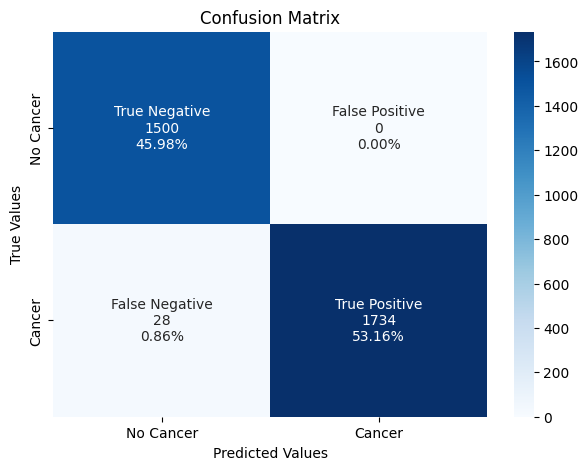

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training:  46%|████▋     | 38/82 [00:20<00:23,  1.84batch/s, accuracy=95.6, loss=0.00172]


KeyboardInterrupt: 

In [48]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 32,  # Taille du batch pour la validation
    "train_batch_size": 80,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 10,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
# model = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

# version = '3.0.0'

#train_model_cross_validation(model,processed_df,hyperparameters)

Shape Of Train Sample: (8057, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,35295,603664888,1,1,73.0,0,0,No Cancer,/kaggle/working/Processed Image/35295/60366488...
1,20391,520507163,1,1,57.0,0,0,No Cancer,/kaggle/working/Processed Image/20391/52050716...
2,56742,1683721941,1,5,50.0,0,0,No Cancer,/kaggle/working/Processed Image/56742/16837219...
3,31758,336430653,1,1,48.0,0,0,No Cancer,/kaggle/working/Processed Image/31758/33643065...
4,47844,727384240,1,1,50.0,0,0,No Cancer,/kaggle/working/Processed Image/47844/72738424...


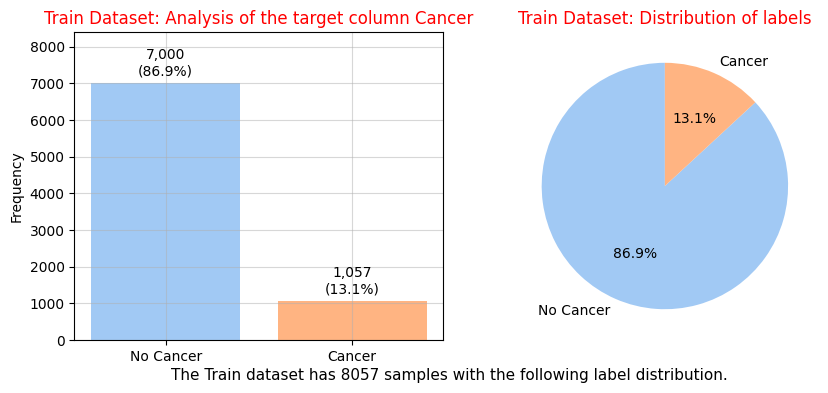

In [118]:
# Sample down for dev
num_class_0,num_class_1 = 7000, 1057 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(df_train, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)
plot_label_distribution(sample_train,'Train')

Shape Of Train Sample: (601, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,61707,1790684648,1,1,62.0,0,0,No Cancer,/kaggle/working/Processed Image/61707/17906846...
1,19277,1275907951,1,5,47.0,1,0,No Cancer,/kaggle/working/Processed Image/19277/12759079...
2,3626,1942920371,0,1,82.0,0,1,Cancer,/kaggle/working/Processed Image/3626/194292037...
3,6445,197683890,1,1,74.0,0,0,No Cancer,/kaggle/working/Processed Image/6445/197683890...
4,32880,554197513,1,5,69.0,0,0,No Cancer,/kaggle/working/Processed Image/32880/55419751...


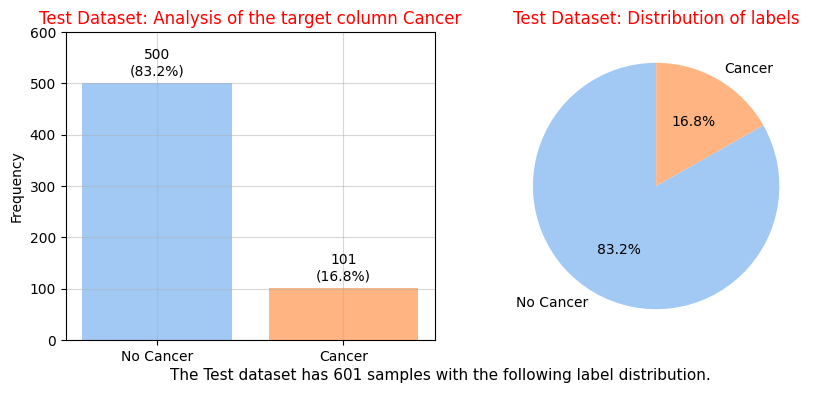

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 21/21 [00:34<00:00,  1.62s/batch]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.28      0.48      0.35       101
   No Cancer       0.88      0.75      0.81       500

    accuracy                           0.70       601
   macro avg       0.58      0.61      0.58       601
weighted avg       0.78      0.70      0.73       601



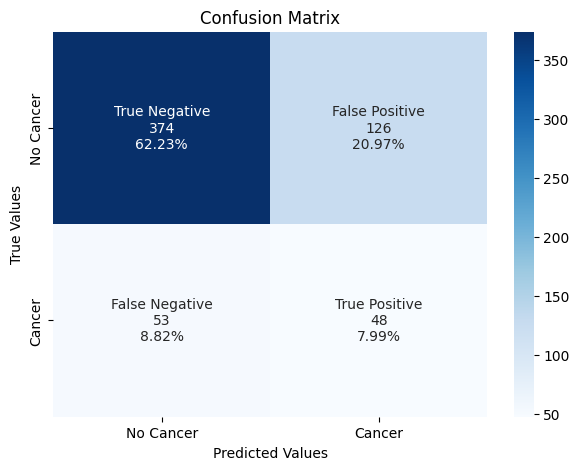

In [65]:
# Sample down for dev
num_class_0,num_class_1 = 500,101 #7000, 1057 # full dataset ===> 1500, 1158
sample_test = create_subset_train(df_test, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_test.shape}')
display(sample_test.head())
print("======="*25)
plot_label_distribution(sample_test,'Test')

print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3

test_data = sample_test.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(test_data,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [ ]:
from torch.utils.data import Dataset
import cv2
import numpy as np
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

class CustomRSNATestDataset(Dataset):
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Apply resizing for processed images
        image = cv2.imread(image_path).astype(np.float32) / 255.0
        image = cv2.resize(image, self.resize_dims)  # Resize image to specified dimensions

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {
            "image": transf_image,
            "meta": csv_data
        }

In [87]:
from torch.utils.data import Dataset
import cv2
import numpy as np
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

class CustomRSNATestDataset(Dataset):
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {
            "image": transf_image,
            "meta": csv_data,
            "target": self.dataframe['cancer'][index]
        }


Shape Of Train Sample: (601, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,61707,1790684648,1,1,62.0,0,0,No Cancer,/kaggle/working/Processed Image/61707/17906846...
1,19277,1275907951,1,5,47.0,1,0,No Cancer,/kaggle/working/Processed Image/19277/12759079...
2,3626,1942920371,0,1,82.0,0,1,Cancer,/kaggle/working/Processed Image/3626/194292037...
3,6445,197683890,1,1,74.0,0,0,No Cancer,/kaggle/working/Processed Image/6445/197683890...
4,32880,554197513,1,5,69.0,0,0,No Cancer,/kaggle/working/Processed Image/32880/55419751...


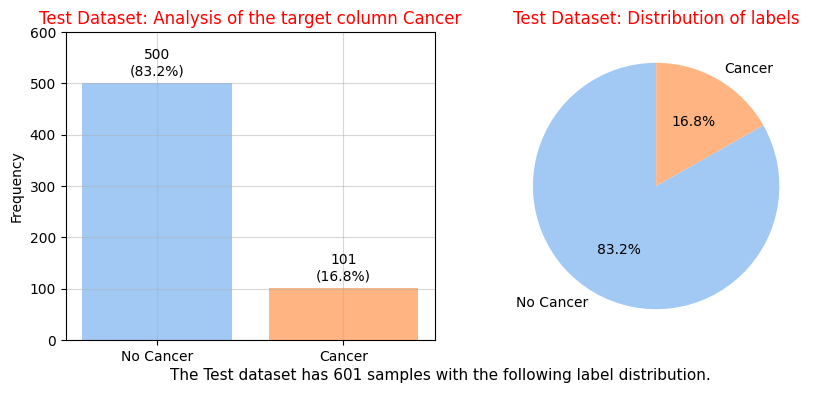

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 21/21 [00:01<00:00, 13.40batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.31      0.35      0.33       101
   No Cancer       0.87      0.85      0.86       500

    accuracy                           0.76       601
   macro avg       0.59      0.60      0.59       601
weighted avg       0.77      0.76      0.77       601



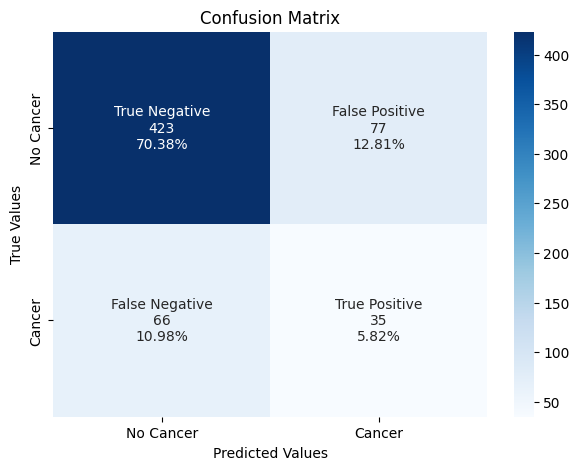

In [91]:
# Sample down for dev
num_class_0,num_class_1 = 500,101 #7000, 1057 # full dataset ===> 1500, 1158
sample_test = create_subset_train(df_test, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_test.shape}')
display(sample_test.head())
print("======="*25)
plot_label_distribution(sample_test,'Test')

print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3

test_data = sample_test.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = CustomRSNATestDataset(test_data,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [90]:
save_best_model_dir

'/kaggle/working/Best Model'

In [ ]:
FOLDS = 3
EPOCHS = 10
PATIENCE = 3
WORKERS = 10

version = '3.0'

# Configuration of hyperparameters
train_batch_size = 80 #64
test_batch_size = 32 #32
val_batch_size = 80 #32
num_workers = 4

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 10
early_stopping_patience = 3
best_model_state = None


base_path = save_best_model_dir  

# Create a dictionary to store the hyperparameters
model_EffNetNetwork = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

train_folds(model=model_EffNetNetwork, train_original=processed_df)

In [ ]:
def train_model_cross_validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Early stopping
    best_overall_val_f1_score = float('-inf')  # Initialize the overall best validation F1 score
    best_model_state = None  # Initialize the best model state
    best_overall_model_state = None  # Initialize the overall best model state
    best_overall_metrics = {}  # Initialize the overall best model metrics

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        print(Color.S + f"---------- Fold: {fold_idx + 1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Lists to store metrics for plotting
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = []

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(Color.S + f"Training the model" + Color.E)
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)
            
            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(Color.S + f"Validating the trained model's performance" + Color.E)
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation loss: {val_loss:.4f}')

            # Scheduler step
            scheduler.step(val_loss)

            # Append metrics for plotting
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Check early stopping conditions
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                best_model_state = model.state_dict()
                trigger_times = 0  # Reset trigger times if there is an improvement
            else:
                trigger_times += 1  # Increment trigger times if there is no improvement

            # If trigger times exceed patience, load the best model state
            if trigger_times >= patience:
                print(f"Early stopping triggered. Restoring best model state for fold {fold_idx + 1}.")
                model.load_state_dict(best_model_state)
                break

        # Save the best model state for the current fold
        if best_model_state:
            torch.save(best_model_state, f"model_fold_{fold_idx + 1}.pth")

        # Update the overall best model state if current fold's model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                "accuracy": val_accuracy,
                "roc": val_roc,
                "precision": val_precision,
                "recall": val_recall,
                "f1_score": val_f1,
            }

        # Plot results after each fold
        plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save the best overall model state after all folds
    if best_overall_model_state:
        torch.save(best_overall_model_state, "best_overall_model.pth")
        print("Best overall model state saved.")

        # Log the best overall metrics
        add_in_file("Best Overall Metrics:", log_file_path)
        add_in_file(f"Accuracy: {best_overall_metrics['accuracy']}", log_file_path)
        add_in_file(f"ROC: {best_overall_metrics['roc']}", log_file_path)
        add_in_file(f"Precision: {best_overall_metrics['precision']}", log_file_path)
        add_in_file(f"Recall: {best_overall_metrics['recall']}", log_file_path)
        add_in_file(f"F1 Score: {best_overall_metrics['f1_score']}", log_file_path)

    # Close the log file
    close_file(log_file_path)

    print(f"Training complete. Best overall validation F1 score: {best_overall_val_f1_score:.4f}")

XceptionNetwork

In [ ]:
from torchvision.models import xception
import torch.nn as nn
import torch.nn.functional as F
import torch

class XceptionNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = xception(weights='IMAGENET1K_V1')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


LeNetNetwork

In [ ]:
class LeNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(16*5*5 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = image.view(-1, 16*5*5)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [1]:
from torchvision.models import inception_v3

class InceptionV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = inception_v3(weights='IMAGENET1K_V1', aux_logits=False)
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


NameError: name 'nn' is not defined

VGG16Network

In [ ]:
from torchvision.models import vgg16

class VGG16Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = vgg16(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(512*7*7 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (7, 7)).reshape(-1, 512*7*7)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [ ]:
from torchvision.models import mobilenet_v3_large

class MobileNetV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = mobilenet_v3_large(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(960 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 960)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


In [ ]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt

def apply_and_visualize_transformations(img_path, transformations):
    """
    Applies a list of transformations to an image and visualizes the results.
    
    Parameters:
    - img_path: Path to the image file.
    - transformations: List of albumentations.Compose transformations.
    """
    # Load and prepare the image
    img = Image.open(img_path)
    img = np.asarray(img)

    # Calculate the number of rows needed
    num_transformations = len(transformations)
    num_rows = num_transformations
    num_cols = 2  # Original and transformed image

    # Create a figure to display the images
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, num_rows * 5))
    axs = axs.flatten()

    # Iterate over each transformation and its index
    for i, transformation in enumerate(transformations):
        transformed_img = transformation(image=img)['image']
        
        # Display the original image
        axs[i * 2].imshow(img)
        axs[i * 2].set_title(f'Original Image')
        axs[i * 2].axis('off')

        # Display the transformed image
        axs[i * 2 + 1].imshow(transformed_img)
        axs[i * 2 + 1].set_title(f'Transformed Image {i + 1}')
        axs[i * 2 + 1].axis('off')

    # Hide any extra axes if the number of transformations is less than the maximum possible rows
    for j in range(num_transformations * num_cols, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# Définir les transformations avec albumentations
height, width = 256, 256

#Liste de transformations
#transform1 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])
#transform2 = A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75), A.Blur(blur_limit=3, p=0.2), A.OpticalDistortion(p=0.3), A.GridDistortion(p=0.3), A.HueSaturationValue(p=0.3)])
#transform3 = A.Compose([A.SmallestMaxSize(max_size=160), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7), A.RandomCrop(height=128, width=128), A.RandomBrightnessContrast(p=0.5)])
#transform4 = A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)])
#transform5 = A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5), A.InvertImg(p=0.5)])
#transform6 = A.Compose([A.Equalize(p=0.5), A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), A.ISONoise(p=0.5)])
#transform7 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5), A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.15, alpha_coef=0.05, p=0.3)])
#transform8 = A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=0.5), A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.5), A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, p=0.5)])
#transform9 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5), A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)])
#transform10 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5)])

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.RandomCrop(height=234, width=234, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.CenterCrop(height=200, width=200, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.HorizontalFlip(p=0.9), A.VerticalFlip(p=0.7)]),
    A.Compose([A.HorizontalFlip(p=0.4), A.VerticalFlip(p=0.3), A.RandomBrightnessContrast(p=0.1)])
]

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
]

custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.3),A.Transpose(p=0.45),A.ShiftScaleRotate(shift_limit=0.0725, scale_limit=0.60)]),
    A.Compose([A.RandomRotate90(p=0.7),A.Transpose(p=0.67),A.ShiftScaleRotate(shift_limit=0.0005, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)])
]